# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo, aplicando experimentos para identificar a melhor janela.

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install statstests

In [2]:
import os
import tqdm
import math
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from warnings import filterwarnings
from statstests.tests import overdisp
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy.stats import poisson, nbinom
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from typing import Dict, List, Set, Tuple, Optional, Any, Union
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

## Carregamento de dados e ajuste de dados/valores

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Mounted at /content/drive


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

shape: (5, 38)
┌─────────┬────────────┬───────────┬─────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ id      ┆ date       ┆ client_id ┆ card_id ┆ … ┆ credit_lim ┆ acct_open_ ┆ year_pin_ ┆ card_on_d │
│ ---     ┆ ---        ┆ ---       ┆ ---     ┆   ┆ it         ┆ date       ┆ last_chan ┆ ark_web   │
│ i64     ┆ datetime[n ┆ i64       ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ged       ┆ ---       │
│         ┆ s]         ┆           ┆         ┆   ┆ f64        ┆ str        ┆ ---       ┆ str       │
│         ┆            ┆           ┆         ┆   ┆            ┆            ┆ i64       ┆           │
╞═════════╪════════════╪═══════════╪═════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 7475328 ┆ 2010-01-01 ┆ 561       ┆ 4575    ┆ … ┆ 9100.0     ┆ 09/2005    ┆ 2015      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475329 ┆ 2010-01-01 ┆ 1129      ┆ 102     ┆ … ┆ 14802.0    ┆ 01/2006    ┆ 2008      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475332 ┆ 2010-01-01 ┆ 848       ┆ 3915    ┆ … ┆ 19113.0    ┆ 07/2009    ┆ 2014      ┆ No        │
│         ┆ 00:06:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475333 ┆ 2010-01-01 ┆ 1807      ┆ 165     ┆ … ┆ 89.0       ┆ 01/2008    ┆ 2015      ┆ No        │
│         ┆ 00:07:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475335 ┆ 2010-01-01 ┆ 1684      ┆ 2140    ┆ … ┆ 46.0       ┆ 03/2007    ┆ 2012      ┆ No        │
│         ┆ 00:14:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
└─────────┴────────────┴───────────┴─────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
df.shape

(8472184, 38)

In [6]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [7]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

## Scripts de código

Scripts para pre-processar e transformar os dados em função da janela de tempo.

### **Análise e Documentação Corrigida do Processo de Feature Engineering**

O script transforma dados transacionais brutos em um conjunto de features agregadas por janelas de tempo, prontas para serem usadas em modelos de detecção de fraude. O processo pode ser dividido em três etapas principais: tratamento de variáveis numéricas, categóricas e seleção final de features.

---

### ## 1. Agregação e Features Numéricas

As features numéricas são criadas agrupando os dados por uma janela de tempo (`date_window`) e aplicando as seguintes operações:

#### **Contagens e Razões**
São calculadas contagens e razões para entender o volume e a distribuição das transações em cada janela:
* `frauds`: Contagem total de fraudes (soma da coluna `target`).
* `transaction_per_client`: Média de transações por cliente único na janela.
* `transaction_per_merchant`: Média de transações por comerciante único na janela.

#### **Estatísticas de Comportamento**
Para um conjunto de colunas numéricas, são calculadas estatísticas para capturar a distribuição dos valores dentro da janela. Algumas dessas colunas são **normalizadas por um fator de escala** para manter os valores em uma ordem de magnitude similar.

* **Colunas com Fator de Escala:**
    * `amount` / 1.000
    * `per_capita_income` / 1.000
    * `total_debt` / 10.000
    * `credit_score` / 100
    * `credit_limit` / 10.000
* **Colunas Sem Fator de Escala:**
    * `current_age`
    * `num_credit_cards`

* **Estatísticas Geradas para as Colunas Acima:**
    * **Média (`mean_`):** Valor médio da feature na janela.
    * **Desvio Padrão (`std_`):** Dispersão dos valores da feature na janela.
    * **Mínimo (`min_`) e Máximo (`max_`):** O script calcula esses valores, mas as colunas `min_amount` e `max_amount` são **removidas** ao final desta etapa por serem consideradas menos informativas ou redundantes.

---

### ## 2. Features Categóricas (`city`, `country`, `description`)

O tratamento de variáveis categóricas é mais complexo e visa transformar categorias (como cidades) em representações numéricas que capturem seu risco de fraude. O fluxo é o seguinte:

1.  **Cálculo da Razão de Risco:** Para cada valor único de uma categoria (ex: para cada cidade), calcula-se a razão entre a porcentagem de transações fraudulentas e a porcentagem de transações não fraudulentas. Isso cria um "score de risco" para cada cidade.

2.  **Clusterização (KMeans):** As cidades são agrupadas (`clusterizadas`) em um número fixo de grupos (por padrão, 3) com base em seu "score de risco". Cidades com perfis de fraude semelhantes ficam no mesmo cluster.

3.  **Criação de Dummies:** Os clusters são transformados em colunas dummy (ex: `target_city_0`, `target_city_1`, `target_city_2`). Cada transação recebe o valor 1 na coluna do cluster correspondente à sua cidade e 0 nas outras.

4.  **Agregação por Janela (Proporção):** Finalmente, para cada janela de tempo, o script calcula a **proporção** de transações que pertencem a cada um dos clusters. Por exemplo, uma janela pode ter 70% de suas transações em cidades de "baixo risco" (cluster 0), 20% em cidades de "médio risco" (cluster 1) e 10% em cidades de "alto risco" (cluster 2).

O fluxo completo pode ser resumido como: **Razão de Risco → Clusterização → Variáveis Dummy → Proporção por Janela**.

---

### ## 3. Seleção de Features (Pós-processamento)

Após a criação de todas as features numéricas e categóricas, é executada uma etapa final de seleção para reduzir a redundância e o ruído:

* **Remoção de Features Altamente Correlacionadas:** O script calcula a matriz de correlação entre todas as features geradas. Se duas features tiverem uma correlação maior que um limiar (definido como **0.75**), aquela com a **menor variância** é removida. Isso ajuda a evitar problemas de multicolinearidade no modelo final.

In [8]:
# class WindowDataBuilder:
#     """
#     Builder class for creating time-windowed features for fraud detection.

#     This class transforms raw transaction data into aggregated features
#     organized by time windows, specifically designed for fraud detection models.
#     """

#     # Class constants for better maintainability
#     CATEGORICAL_COLUMNS = ['city', 'country', 'description']
#     DEFAULT_CORRELATION_THRESHOLD = 0.75
#     DEFAULT_N_CLUSTERS = 3
#     DEFAULT_MIN_BINS = 1
#     DEFAULT_MAX_BINS = 5

#     # Scale factors for feature normalization
#     SCALE_FACTORS = {
#         'amount': 1_000,
#         'per_capita_income': 1_000,
#         'total_debt': 10_000,
#         'credit_score': 100,
#         'credit_limit': 10_000,
#     }

#     # Numerical columns for discretization
#     NUMERICAL_COLUMNS_FOR_DISCRETIZATION = [
#         'amount', 'per_capita_income', 'total_debt', 'credit_score',
#         'credit_limit', 'current_age', 'num_credit_cards'
#     ]

#     def __init__(self, df: pl.DataFrame, method_corr='pearson', save_features_corr=None,
#                  discretize_numerical=True, discretization_strategy='uniform'):
#         """
#         Initialize the WindowDataBuilder.

#         Args:
#             df (pl.DataFrame): Input DataFrame containing transaction data
#             method_corr (str): Correlation method for feature selection
#             save_features_corr: Features to save from correlation removal
#             discretize_numerical (bool): Whether to discretize numerical features
#             discretization_strategy (str): Strategy for discretization ('uniform' or 'quantile')

#         Raises:
#             ValueError: If required columns are missing from the DataFrame
#         """
#         self._validate_input_data(df)
#         self.df = df
#         self._scaler = MinMaxScaler()
#         self.method_corr = method_corr
#         self.save_features_corr = save_features_corr
#         self.discretize_numerical = discretize_numerical
#         self.discretization_strategy = discretization_strategy

#     def _validate_input_data(self, df: pl.DataFrame) -> None:
#         """Validate that required columns exist in the input DataFrame."""
#         required_columns = {'date', 'target', 'client_id', 'merchant_id', 'amount'}
#         missing_columns = required_columns - set(df.columns)
#         if missing_columns:
#             raise ValueError(f"Missing required columns: {missing_columns}")

#     def create_cluster_target_fields(
#         self,
#         df: pl.DataFrame,
#         group_column_name: str,
#         target_column_name: str,
#         n_clusters: int = DEFAULT_N_CLUSTERS,
#         drop_first: bool = False
#     ) -> pl.DataFrame:
#         """
#         Create clustered categorical features based on target variable patterns.

#         Args:
#             df: Input DataFrame
#             group_column_name: Column to group by
#             target_column_name: Target variable column
#             n_clusters: Number of clusters for KMeans
#             drop_first: Whether to drop first dummy variable

#         Returns:
#             DataFrame with clustered dummy variables
#         """
#         try:
#             # Define column names for better readability
#             percent_target_col = f'percent_{target_column_name}'
#             percent_no_target_col = f'percent_no_{target_column_name}'
#             ab_col = 'ab'
#             target_cluster_col = f'{target_column_name}_{group_column_name}'

#             # Calculate target percentages by group
#             df_cat_group = (
#                 df.group_by(group_column_name)
#                 .agg([
#                     ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(percent_target_col),
#                     (((pl.count() - pl.col(target_column_name).sum()) / pl.count()) * 100).alias(percent_no_target_col)
#                 ])
#                 .with_columns([
#                     # Calculate A/B ratio with proper handling of edge cases
#                     pl.when(pl.col(percent_no_target_col) == 0)
#                     .then(pl.lit(100.0))
#                     .otherwise(pl.col(percent_target_col) / pl.col(percent_no_target_col))
#                     .alias(ab_col)
#                 ])
#                 .with_columns([
#                     # Cap the A/B ratio at 100 for stability
#                     pl.when(pl.col(ab_col) > 100.0)
#                     .then(pl.lit(100.0))
#                     .otherwise(pl.col(ab_col))
#                     .alias(ab_col)
#                 ])
#             )

#             # Apply clustering
#             ab_values = df_cat_group.select(ab_col).to_pandas()
#             scaled_values = self._scaler.fit_transform(ab_values)

#             kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
#             cluster_labels = kmeans.fit_predict(scaled_values)

#             # Add cluster labels and create dummy variables
#             df_cat_group = df_cat_group.with_columns(
#                 pl.lit(cluster_labels).alias(target_cluster_col)
#             )

#             return (
#                 df_cat_group
#                 .select([group_column_name, target_cluster_col])
#                 .to_dummies(columns=[target_cluster_col], drop_first=drop_first)
#             )

#         except Exception as e:
#             raise RuntimeError(f"Error in create_cluster_target_fields: {str(e)}")

#     def _discretize_numerical_features(self, df: pl.DataFrame) -> Dict[str, pl.DataFrame]:
#         """
#         Discretize numerical features based on their amplitude.

#         Args:
#             df: Input DataFrame with numerical columns

#         Returns:
#             Dictionary with discretized features for each numerical column
#         """
#         discretized_features = {}

#         try:
#             for column in self.NUMERICAL_COLUMNS_FOR_DISCRETIZATION:
#                 if column not in df.columns:
#                     continue

#                 # Convert to pandas for sklearn processing
#                 column_data = df.select([column, 'target']).to_pandas()

#                 # Skip if column has insufficient data
#                 if column_data[column].isna().all() or column_data[column].nunique() < 2:
#                     continue

#                 # Calculate amplitude and determine number of bins
#                 min_val = column_data[column].min()
#                 max_val = column_data[column].max()
#                 amplitude = max_val - min_val

#                 # Determine number of bins based on data distribution
#                 unique_vals = column_data[column].nunique()
#                 n_bins = min(
#                     max(self.DEFAULT_MIN_BINS, min(unique_vals // 10, self.DEFAULT_MAX_BINS)),
#                     unique_vals
#                 )

#                 if n_bins < 2:
#                     continue

#                 # Apply discretization
#                 discretizer = KBinsDiscretizer(
#                     n_bins=n_bins,
#                     encode='ordinal',
#                     strategy=self.discretization_strategy,
#                     subsample=None
#                 )

#                 # Fit and transform the data
#                 discretized_values = discretizer.fit_transform(
#                     column_data[[column]].fillna(column_data[column].median())
#                 ).astype(int)

#                 # Create DataFrame with discretized values
#                 discretized_df = pl.DataFrame({
#                     f'{column}_discretized': discretized_values.flatten(),
#                     'target': column_data['target'].values
#                 })

#                 # Create dummy variables directly from discretized bins (no clustering needed)
#                 df_discretized_dummies = (
#                     discretized_df
#                     .select([f'{column}_discretized'])
#                     .to_dummies(columns=[f'{column}_discretized'], drop_first=False)
#                 )

#                 if not df_discretized_dummies.is_empty():
#                     discretized_features[column] = df_discretized_dummies

#         except Exception as e:
#             print(f"Warning: Error in discretization: {str(e)}")

#         return discretized_features

#     def _process_discretized_numerical_features(
#         self,
#         df: pl.DataFrame,
#         discretized_features: Dict[str, pl.DataFrame]
#     ) -> pl.DataFrame:
#         """
#         Process discretized numerical features similar to categorical features.

#         Args:
#             df: Original DataFrame with date_window
#             discretized_features: Dictionary with discretized features

#         Returns:
#             DataFrame with discretized features aggregated by time window
#         """
#         if not discretized_features:
#             return pl.DataFrame({'date_window': df.select('date_window').unique().to_pandas()['date_window']})

#         result_features = []

#         try:
#             for column, df_discretized in discretized_features.items():
#                 # Add original data back for aggregation
#                 df_with_discretized = (
#                     df.select(['date_window']).with_row_index()
#                     .join(
#                         df_discretized.with_row_index(),
#                         on='index',
#                         how='left'
#                     )
#                     .drop(['index'])
#                 )

#                 # Aggregate by time window
#                 df_agg = (
#                     df_with_discretized.group_by('date_window')
#                     .sum()
#                 )

#                 # Calculate proportions if there are discretized features
#                 if len(df_agg.columns) > 1:
#                     df_agg = df_agg.with_columns(
#                         pl.sum_horizontal([
#                             pl.col(col) for col in df_agg.columns[1:]
#                         ]).alias('total')
#                     )

#                     # Calculate proportions for each discretized bin
#                     proportion_expressions = [
#                         (pl.col(col) / pl.col('total')).alias(f'{column}_{col}')
#                         for col in df_agg.columns[1:-1]  # Exclude date_window and total
#                     ]

#                     if proportion_expressions:
#                         df_agg = (
#                             df_agg.with_columns(proportion_expressions)
#                             .select(['date_window'] + [f'{column}_{col}' for col in df_agg.columns[1:-1]])
#                         )
#                         result_features.append(df_agg)

#         except Exception as e:
#             print(f"Warning: Error processing discretized features: {str(e)}")

#         # Combine all discretized features
#         if result_features:
#             combined_df = result_features[0]
#             for df_feat in result_features[1:]:
#                 combined_df = combined_df.join(df_feat, on='date_window', how='outer', suffix='_dup')
#                 # Remove duplicate columns created by join
#                 duplicate_cols = [col for col in combined_df.columns if col.endswith('_dup')]
#                 if duplicate_cols:
#                     combined_df = combined_df.drop(duplicate_cols)
#             return combined_df
#         else:
#             return pl.DataFrame({'date_window': df.select('date_window').unique().to_pandas()['date_window']})

#     def _generate_column_statistics(self, column_name: str, divide_by: float = 1.0) -> List[pl.Expr]:
#         """
#         Generate statistical aggregations for a column.

#         Args:
#             column_name: Name of the column to generate statistics for
#             divide_by: Scaling factor for normalization

#         Returns:
#             List of Polars expressions for statistical aggregations
#         """
#         return [
#             (pl.col(column_name).min() / divide_by).alias(f'min_{column_name}'),
#             (pl.col(column_name).mean() / divide_by).alias(f'mean_{column_name}'),
#             (pl.col(column_name).max() / divide_by).alias(f'max_{column_name}'),
#             (pl.col(column_name).std() / divide_by).alias(f'std_{column_name}'),
#         ]

#     def _create_base_features(self, df: pl.DataFrame) -> pl.DataFrame:
#         """
#         Create base numerical features aggregated by time window.

#         Args:
#             df: Input DataFrame with date_window column

#         Returns:
#             DataFrame with aggregated numerical features
#         """
#         try:
#             # Build aggregation expressions dynamically
#             agg_expressions = [
#                 pl.col("target").sum().alias("frauds"),
#                 pl.col("target").count().alias("transactions"),
#                 pl.col("client_id").n_unique().alias("unique_clients"),
#                 pl.col("merchant_id").n_unique().alias("unique_merchants"),
#                 pl.col("amount").sum().alias("total_amount"),
#             ]

#             # Add statistical features for numerical columns only if discretization is disabled
#             if not self.discretize_numerical:
#                 # Add statistical features for numerical columns
#                 for column, scale_factor in self.SCALE_FACTORS.items():
#                     if column in df.columns:
#                         agg_expressions.extend(
#                             self._generate_column_statistics(column, scale_factor)
#                         )

#                 # Add statistics for columns without scaling
#                 for column in ['current_age', 'num_credit_cards']:
#                     if column in df.columns:
#                         agg_expressions.extend(
#                             self._generate_column_statistics(column, 1.0)
#                         )

#             # Perform aggregation
#             df_features = (
#                 df.group_by("date_window")
#                 .agg(agg_expressions)
#                 .with_columns([
#                     (pl.col("transactions") / pl.col("unique_clients")).alias("transaction_per_client"),
#                     (pl.col("transactions") / pl.col("unique_merchants")).alias("transaction_per_merchant"),
#                 ])
#             )

#             # Remove columns based on discretization setting
#             columns_to_drop = ["transactions", "total_amount", "unique_clients", "unique_merchants"]

#             # Only drop min/max amount columns if discretization is disabled (they were created)
#             if not self.discretize_numerical:
#                 columns_to_drop.extend([f"min_{col}" for col in ["amount"] if col in df.columns])
#                 columns_to_drop.extend([f"max_{col}" for col in ["amount"] if col in df.columns])

#             df_features = df_features.drop([col for col in columns_to_drop if col in df_features.columns]).drop_nulls()

#             return df_features

#         except Exception as e:
#             raise RuntimeError(f"Error creating base features: {str(e)}")

#     def _process_categorical_features(self, df: pl.DataFrame, df_base: pl.DataFrame) -> pl.DataFrame:
#         """
#         Process categorical features and merge with base features.

#         Args:
#             df: Original DataFrame with categorical columns
#             df_base: Base features DataFrame

#         Returns:
#             DataFrame with categorical and numerical features combined
#         """
#         result_df = df_base

#         for column in self.CATEGORICAL_COLUMNS:
#             if column not in df.columns:
#                 continue

#             try:
#                 # Create cluster features for categorical column
#                 df_target_cat = self.create_cluster_target_fields(
#                     df, column, 'target', drop_first=False
#                 )

#                 # Aggregate categorical features by time window
#                 df_with_cat = (
#                     df.select(['date_window', column])
#                     .join(df_target_cat, on=column, how='left')
#                     .drop(column)
#                     .group_by('date_window')
#                     .sum()
#                 )

#                 # Calculate proportions if there are categorical features
#                 if len(df_with_cat.columns) > 1:
#                     df_with_cat = df_with_cat.with_columns(
#                         pl.sum_horizontal([
#                             pl.col(col) for col in df_with_cat.columns[1:]
#                         ]).alias('total')
#                     )

#                     # Calculate proportions for each categorical feature
#                     proportion_expressions = [
#                         (pl.col(col) / pl.col('total')).alias(col)
#                         for col in df_with_cat.columns[1:-1]  # Exclude date_window and total
#                     ]

#                     if proportion_expressions:
#                         df_with_cat = (
#                             df_with_cat.with_columns(proportion_expressions)
#                             .drop('total')
#                         )

#                     # Merge with result DataFrame
#                     result_df = result_df.join(df_with_cat, on='date_window', how='left')

#             except Exception as e:
#                 print(f"Warning: Error processing categorical column '{column}': {str(e)}")
#                 continue

#         return result_df

#     def _remove_highly_correlated_features(
#         self,
#         df: pd.DataFrame,
#         threshold: float = DEFAULT_CORRELATION_THRESHOLD
#     ) -> List[str]:
#         """
#         Identify features with high correlation for removal.

#         Args:
#             df: Input DataFrame
#             threshold: Correlation threshold for removal

#         Returns:
#             List of column names to remove
#         """
#         try:
#             if df.empty or len(df.columns) <= 1:
#                 return []

#             # Calculate correlation matrix more efficiently
#             corr_matrix = df.corr(numeric_only=True, method=self.method_corr)

#             # Create mask for upper triangle
#             upper_triangle = np.triu(np.abs(corr_matrix), k=1)

#             # Find highly correlated pairs
#             high_corr_pairs = np.where(upper_triangle > threshold)
#             columns_to_remove: Set[str] = set()

#             # Process correlated pairs
#             for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
#                 col_i = corr_matrix.columns[i]
#                 col_j = corr_matrix.columns[j]

#                 # Skip if either column already marked for removal
#                 if col_i in columns_to_remove or col_j in columns_to_remove:
#                     continue

#                 # Remove column with lower variance
#                 var_i = df[col_i].var()
#                 var_j = df[col_j].var()

#                 if pd.isna(var_i) or pd.isna(var_j):
#                     continue

#                 if var_i < var_j:
#                     columns_to_remove.add(col_i)
#                 else:
#                     columns_to_remove.add(col_j)

#             return list(columns_to_remove)

#         except Exception as e:
#             print(f"Warning: Error in correlation analysis: {str(e)}")
#             return []

#     def build(self, window: str, remove_high_correlation=True) -> pd.DataFrame:
#         """
#         Build the complete feature dataset for the specified time window.

#         Args:
#             window: Time window specification (e.g., '1d', '1w', '1mo')

#         Returns:
#             pandas DataFrame with engineered features ready for modeling

#         Raises:
#             ValueError: If window specification is invalid
#             RuntimeError: If feature engineering fails
#         """
#         try:
#             if not isinstance(window, str) or not window.strip():
#                 raise ValueError("Window must be a non-empty string")

#             # Create time windows
#             df_windowed = self.df.with_columns(
#                 pl.col('date').dt.truncate(window).alias('date_window')
#             )

#             # Create base numerical features
#             df_base = self._create_base_features(df_windowed)

#             # Process categorical features
#             df_with_categories = self._process_categorical_features(df_windowed, df_base)

#             # Process discretized numerical features if enabled
#             result_df = df_with_categories
#             if self.discretize_numerical:
#                 discretized_features = self._discretize_numerical_features(df_windowed)
#                 df_discretized = self._process_discretized_numerical_features(
#                     df_windowed, discretized_features
#                 )

#                 # Merge discretized features if they exist
#                 if not df_discretized.is_empty() and len(df_discretized.columns) > 1:
#                     result_df = result_df.join(df_discretized, on='date_window', how='left')
#                     print(f"Added {len(df_discretized.columns) - 1} discretized numerical features")

#             # Convert to pandas for correlation analysis
#             df_pandas = result_df.to_pandas()

#             # Remove highly correlated features
#             removed_columns = ['date_window']
#             if self.save_features_corr:
#               if isinstance(self.save_features_corr, str):
#                 removed_columns.append(self.save_features_corr)
#               elif isinstance(self.save_features_corr, list):
#                 removed_columns.extend(self.save_features_corr)
#             columns_to_remove = self._remove_highly_correlated_features(
#                 df_pandas.drop(columns=removed_columns, errors='ignore')
#             )

#             if columns_to_remove and remove_high_correlation:
#                 df_pandas = df_pandas.drop(columns=columns_to_remove, errors='ignore')
#                 print(f"Removed {len(columns_to_remove)} highly correlated features")
#                 print(f'Columns removed: {", ".join(columns_to_remove)}')

#             return df_pandas.sort_values('date_window')

#         except Exception as e:
#             raise RuntimeError(f"Error building features: {str(e)}")

#     def get_feature_info(self) -> dict:
#         """
#         Get information about the feature engineering process.

#         Returns:
#             Dictionary with feature engineering configuration
#         """
#         return {
#             'categorical_columns': self.CATEGORICAL_COLUMNS,
#             'numerical_columns_for_discretization': self.NUMERICAL_COLUMNS_FOR_DISCRETIZATION,
#             'correlation_threshold': self.DEFAULT_CORRELATION_THRESHOLD,
#             'n_clusters': self.DEFAULT_N_CLUSTERS,
#             'min_bins': self.DEFAULT_MIN_BINS,
#             'max_bins': self.DEFAULT_MAX_BINS,
#             'discretize_numerical': self.discretize_numerical,
#             'discretization_strategy': self.discretization_strategy,
#             'scale_factors': self.SCALE_FACTORS,
#         }

In [9]:
class WindowDataBuilder:
    """
    Builder class for creating time-windowed features for fraud detection.

    This class transforms raw transaction data into aggregated features
    organized by time windows, specifically designed for fraud detection models.
    """

    # Class constants for better maintainability
    CATEGORICAL_COLUMNS = ['city', 'country', 'description']
    DEFAULT_CORRELATION_THRESHOLD = 0.75
    DEFAULT_N_CLUSTERS = 3
    DEFAULT_MIN_BINS = 1
    DEFAULT_MAX_BINS = 5

    # Scale factors for feature normalization
    SCALE_FACTORS = {
        'amount': 1_000,
        'per_capita_income': 1_000,
        'total_debt': 10_000,
        'credit_score': 100,
        'credit_limit': 10_000,
    }

    # Numerical columns for discretization
    NUMERICAL_COLUMNS_FOR_DISCRETIZATION = [
        'amount', 'per_capita_income', 'total_debt', 'credit_score',
        'credit_limit', 'current_age', 'num_credit_cards'
    ]

    def __init__(self, df: pl.DataFrame, method_corr='pearson', save_features_corr=None,
                 discretize_numerical=True, discretization_strategy='uniform'):
        """
        Initialize the WindowDataBuilder.

        Args:
            df (pl.DataFrame): Input DataFrame containing transaction data
            method_corr (str): Correlation method for feature selection
            save_features_corr: Features to save from correlation removal
            discretize_numerical (bool): Whether to discretize numerical features
            discretization_strategy (str): Strategy for discretization ('uniform' or 'quantile')

        Raises:
            ValueError: If required columns are missing from the DataFrame
        """
        self._validate_input_data(df)
        self.df = df
        self._scaler = MinMaxScaler()
        self.method_corr = method_corr
        self.save_features_corr = save_features_corr
        self.discretize_numerical = discretize_numerical
        self.discretization_strategy = discretization_strategy
        # Dicionário para armazenar os intervalos das faixas de discretização
        self.discretization_intervals = {}

    def _validate_input_data(self, df: pl.DataFrame) -> None:
        """Validate that required columns exist in the input DataFrame."""
        required_columns = {'date', 'target', 'client_id', 'merchant_id', 'amount'}
        missing_columns = required_columns - set(df.columns)
        if missing_columns:
            raise ValueError(f"Missing required columns: {missing_columns}")

    def create_cluster_target_fields(
        self,
        df: pl.DataFrame,
        group_column_name: str,
        target_column_name: str,
        n_clusters: int = DEFAULT_N_CLUSTERS,
        drop_first: bool = False
    ) -> pl.DataFrame:
        """
        Create clustered categorical features based on target variable patterns.

        Args:
            df: Input DataFrame
            group_column_name: Column to group by
            target_column_name: Target variable column
            n_clusters: Number of clusters for KMeans
            drop_first: Whether to drop first dummy variable

        Returns:
            DataFrame with clustered dummy variables
        """
        try:
            # Define column names for better readability
            percent_target_col = f'percent_{target_column_name}'
            percent_no_target_col = f'percent_no_{target_column_name}'
            ab_col = 'ab'
            target_cluster_col = f'{target_column_name}_{group_column_name}'

            # Calculate target percentages by group
            df_cat_group = (
                df.group_by(group_column_name)
                .agg([
                    ((pl.col(target_column_name).sum() / pl.count()) * 100).alias(percent_target_col),
                    (((pl.count() - pl.col(target_column_name).sum()) / pl.count()) * 100).alias(percent_no_target_col)
                ])
                .with_columns([
                    # Calculate A/B ratio with proper handling of edge cases
                    pl.when(pl.col(percent_no_target_col) == 0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(percent_target_col) / pl.col(percent_no_target_col))
                    .alias(ab_col)
                ])
                .with_columns([
                    # Cap the A/B ratio at 100 for stability
                    pl.when(pl.col(ab_col) > 100.0)
                    .then(pl.lit(100.0))
                    .otherwise(pl.col(ab_col))
                    .alias(ab_col)
                ])
            )

            # Apply clustering
            ab_values = df_cat_group.select(ab_col).to_pandas()
            scaled_values = self._scaler.fit_transform(ab_values)

            kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
            cluster_labels = kmeans.fit_predict(scaled_values)

            # Add cluster labels and create dummy variables
            df_cat_group = df_cat_group.with_columns(
                pl.lit(cluster_labels).alias(target_cluster_col)
            )

            return (
                df_cat_group
                .select([group_column_name, target_cluster_col])
                .to_dummies(columns=[target_cluster_col], drop_first=drop_first)
            )

        except Exception as e:
            raise RuntimeError(f"Error in create_cluster_target_fields: {str(e)}")

    def _discretize_numerical_features(self, df: pl.DataFrame) -> Dict[str, pl.DataFrame]:
        """
        Discretize numerical features based on their amplitude.

        Args:
            df: Input DataFrame with numerical columns

        Returns:
            Dictionary with discretized features for each numerical column
        """
        discretized_features = {}

        try:
            for column in self.NUMERICAL_COLUMNS_FOR_DISCRETIZATION:
                if column not in df.columns:
                    continue

                # Convert to pandas for sklearn processing
                column_data = df.select([column, 'target']).to_pandas()

                # Skip if column has insufficient data
                if column_data[column].isna().all() or column_data[column].nunique() < 2:
                    continue

                # Calculate amplitude and determine number of bins
                min_val = column_data[column].min()
                max_val = column_data[column].max()
                amplitude = max_val - min_val

                # Determine number of bins based on data distribution
                unique_vals = column_data[column].nunique()
                n_bins = min(
                    max(self.DEFAULT_MIN_BINS, min(unique_vals // 10, self.DEFAULT_MAX_BINS)),
                    unique_vals
                )

                if n_bins < 2:
                    continue

                # Apply discretization
                discretizer = KBinsDiscretizer(
                    n_bins=n_bins,
                    encode='ordinal',
                    strategy=self.discretization_strategy,
                    subsample=None
                )

                # Prepare data for discretization (fill NaN with median)
                clean_data = column_data[[column]].fillna(column_data[column].median())

                # Fit and transform the data
                discretized_values = discretizer.fit_transform(clean_data).astype(int)

                # Capturar os intervalos das faixas geradas pelo discretizador
                bin_edges = discretizer.bin_edges_[0]  # bin_edges_ é uma lista com arrays
                intervals = []

                for i in range(len(bin_edges) - 1):
                    interval = {
                        'bin_id': i,
                        'lower_bound': float(bin_edges[i]),
                        'upper_bound': float(bin_edges[i + 1]),
                        'is_left_inclusive': True,
                        'is_right_inclusive': i == len(bin_edges) - 2  # Última faixa inclui o limite superior
                    }
                    intervals.append(interval)

                # Armazenar os intervalos no dicionário da classe
                self.discretization_intervals[column] = {
                    'intervals': intervals,
                    'n_bins': n_bins,
                    'strategy': self.discretization_strategy,
                    'min_value': float(min_val),
                    'max_value': float(max_val),
                    'median_value': float(column_data[column].median())
                }

                # Create DataFrame with discretized values
                discretized_df = pl.DataFrame({
                    f'{column}_discretized': discretized_values.flatten(),
                    'target': column_data['target'].values
                })

                # Create dummy variables directly from discretized bins (no clustering needed)
                df_discretized_dummies = (
                    discretized_df
                    .select([f'{column}_discretized'])
                    .to_dummies(columns=[f'{column}_discretized'], drop_first=False)
                )

                if not df_discretized_dummies.is_empty():
                    discretized_features[column] = df_discretized_dummies

        except Exception as e:
            print(f"Warning: Error in discretization: {str(e)}")

        return discretized_features

    def _process_discretized_numerical_features(
        self,
        df: pl.DataFrame,
        discretized_features: Dict[str, pl.DataFrame]
    ) -> pl.DataFrame:
        """
        Process discretized numerical features similar to categorical features.

        Args:
            df: Original DataFrame with date_window
            discretized_features: Dictionary with discretized features

        Returns:
            DataFrame with discretized features aggregated by time window
        """
        if not discretized_features:
            return pl.DataFrame({'date_window': df.select('date_window').unique().to_pandas()['date_window']})

        result_features = []

        try:
            for column, df_discretized in discretized_features.items():
                # Add original data back for aggregation
                df_with_discretized = (
                    df.select(['date_window']).with_row_index()
                    .join(
                        df_discretized.with_row_index(),
                        on='index',
                        how='left'
                    )
                    .drop(['index'])
                )

                # Aggregate by time window
                df_agg = (
                    df_with_discretized.group_by('date_window')
                    .sum()
                )

                # Calculate proportions if there are discretized features
                if len(df_agg.columns) > 1:
                    df_agg = df_agg.with_columns(
                        pl.sum_horizontal([
                            pl.col(col) for col in df_agg.columns[1:]
                        ]).alias('total')
                    )

                    # Calculate proportions for each discretized bin
                    proportion_expressions = [
                        (pl.col(col) / pl.col('total')).alias(f'{column}_{col}')
                        for col in df_agg.columns[1:-1]  # Exclude date_window and total
                    ]

                    if proportion_expressions:
                        df_agg = (
                            df_agg.with_columns(proportion_expressions)
                            .select(['date_window'] + [f'{column}_{col}' for col in df_agg.columns[1:-1]])
                        )
                        result_features.append(df_agg)

        except Exception as e:
            print(f"Warning: Error processing discretized features: {str(e)}")

        # Combine all discretized features
        if result_features:
            combined_df = result_features[0]
            for df_feat in result_features[1:]:
                combined_df = combined_df.join(df_feat, on='date_window', how='outer', suffix='_dup')
                # Remove duplicate columns created by join
                duplicate_cols = [col for col in combined_df.columns if col.endswith('_dup')]
                if duplicate_cols:
                    combined_df = combined_df.drop(duplicate_cols)
            return combined_df
        else:
            return pl.DataFrame({'date_window': df.select('date_window').unique().to_pandas()['date_window']})

    def _generate_column_statistics(self, column_name: str, divide_by: float = 1.0) -> List[pl.Expr]:
        """
        Generate statistical aggregations for a column.

        Args:
            column_name: Name of the column to generate statistics for
            divide_by: Scaling factor for normalization

        Returns:
            List of Polars expressions for statistical aggregations
        """
        return [
            (pl.col(column_name).min() / divide_by).alias(f'min_{column_name}'),
            (pl.col(column_name).mean() / divide_by).alias(f'mean_{column_name}'),
            (pl.col(column_name).max() / divide_by).alias(f'max_{column_name}'),
            (pl.col(column_name).std() / divide_by).alias(f'std_{column_name}'),
        ]

    def _create_base_features(self, df: pl.DataFrame) -> pl.DataFrame:
        """
        Create base numerical features aggregated by time window.

        Args:
            df: Input DataFrame with date_window column

        Returns:
            DataFrame with aggregated numerical features
        """
        try:
            # Build aggregation expressions dynamically
            agg_expressions = [
                pl.col("target").sum().alias("frauds"),
                pl.col("target").count().alias("transactions"),
                pl.col("client_id").n_unique().alias("unique_clients"),
                pl.col("merchant_id").n_unique().alias("unique_merchants"),
                pl.col("amount").sum().alias("total_amount"),
            ]

            # Add statistical features for numerical columns only if discretization is disabled
            if not self.discretize_numerical:
                # Add statistical features for numerical columns
                for column, scale_factor in self.SCALE_FACTORS.items():
                    if column in df.columns:
                        agg_expressions.extend(
                            self._generate_column_statistics(column, scale_factor)
                        )

                # Add statistics for columns without scaling
                for column in ['current_age', 'num_credit_cards']:
                    if column in df.columns:
                        agg_expressions.extend(
                            self._generate_column_statistics(column, 1.0)
                        )

            # Perform aggregation
            df_features = (
                df.group_by("date_window")
                .agg(agg_expressions)
                .with_columns([
                    (pl.col("transactions") / pl.col("unique_clients")).alias("transaction_per_client"),
                    (pl.col("transactions") / pl.col("unique_merchants")).alias("transaction_per_merchant"),
                ])
            )

            # Remove columns based on discretization setting
            columns_to_drop = ["transactions", "total_amount", "unique_clients", "unique_merchants"]

            # Only drop min/max amount columns if discretization is disabled (they were created)
            if not self.discretize_numerical:
                columns_to_drop.extend([f"min_{col}" for col in ["amount"] if col in df.columns])
                columns_to_drop.extend([f"max_{col}" for col in ["amount"] if col in df.columns])

            df_features = df_features.drop([col for col in columns_to_drop if col in df_features.columns]).drop_nulls()

            return df_features

        except Exception as e:
            raise RuntimeError(f"Error creating base features: {str(e)}")

    def _process_categorical_features(self, df: pl.DataFrame, df_base: pl.DataFrame) -> pl.DataFrame:
        """
        Process categorical features and merge with base features.

        Args:
            df: Original DataFrame with categorical columns
            df_base: Base features DataFrame

        Returns:
            DataFrame with categorical and numerical features combined
        """
        result_df = df_base

        for column in self.CATEGORICAL_COLUMNS:
            if column not in df.columns:
                continue

            try:
                # Create cluster features for categorical column
                df_target_cat = self.create_cluster_target_fields(
                    df, column, 'target', drop_first=False
                )

                # Aggregate categorical features by time window
                df_with_cat = (
                    df.select(['date_window', column])
                    .join(df_target_cat, on=column, how='left')
                    .drop(column)
                    .group_by('date_window')
                    .sum()
                )

                # Calculate proportions if there are categorical features
                if len(df_with_cat.columns) > 1:
                    df_with_cat = df_with_cat.with_columns(
                        pl.sum_horizontal([
                            pl.col(col) for col in df_with_cat.columns[1:]
                        ]).alias('total')
                    )

                    # Calculate proportions for each categorical feature
                    proportion_expressions = [
                        (pl.col(col) / pl.col('total')).alias(col)
                        for col in df_with_cat.columns[1:-1]  # Exclude date_window and total
                    ]

                    if proportion_expressions:
                        df_with_cat = (
                            df_with_cat.with_columns(proportion_expressions)
                            .drop('total')
                        )

                    # Merge with result DataFrame
                    result_df = result_df.join(df_with_cat, on='date_window', how='left')

            except Exception as e:
                print(f"Warning: Error processing categorical column '{column}': {str(e)}")
                continue

        return result_df

    def _remove_highly_correlated_features(
        self,
        df: pd.DataFrame,
        threshold: float = DEFAULT_CORRELATION_THRESHOLD
    ) -> List[str]:
        """
        Identify features with high correlation for removal.

        Args:
            df: Input DataFrame
            threshold: Correlation threshold for removal

        Returns:
            List of column names to remove
        """
        try:
            if df.empty or len(df.columns) <= 1:
                return []

            # Calculate correlation matrix more efficiently
            corr_matrix = df.corr(numeric_only=True, method=self.method_corr)

            # Create mask for upper triangle
            upper_triangle = np.triu(np.abs(corr_matrix), k=1)

            # Find highly correlated pairs
            high_corr_pairs = np.where(upper_triangle > threshold)
            columns_to_remove: Set[str] = set()

            # Process correlated pairs
            for i, j in zip(high_corr_pairs[0], high_corr_pairs[1]):
                col_i = corr_matrix.columns[i]
                col_j = corr_matrix.columns[j]

                # Skip if either column already marked for removal
                if col_i in columns_to_remove or col_j in columns_to_remove:
                    continue

                # Remove column with lower variance
                var_i = df[col_i].var()
                var_j = df[col_j].var()

                if pd.isna(var_i) or pd.isna(var_j):
                    continue

                if var_i < var_j:
                    columns_to_remove.add(col_i)
                else:
                    columns_to_remove.add(col_j)

            return list(columns_to_remove)

        except Exception as e:
            print(f"Warning: Error in correlation analysis: {str(e)}")
            return []

    def build(self, window: str, remove_high_correlation=True) -> tuple[pd.DataFrame, dict]:
        """
        Build the complete feature dataset for the specified time window.

        Args:
            window: Time window specification (e.g., '1d', '1w', '1mo')
            remove_high_correlation: Whether to remove highly correlated features

        Returns:
            tuple: (pandas DataFrame with engineered features ready for modeling,
                   dict with discretization intervals for numerical features)

        Raises:
            ValueError: If window specification is invalid
            RuntimeError: If feature engineering fails
        """
        try:
            if not isinstance(window, str) or not window.strip():
                raise ValueError("Window must be a non-empty string")

            # Create time windows
            df_windowed = self.df.with_columns(
                pl.col('date').dt.truncate(window).alias('date_window')
            )

            # Create base numerical features
            df_base = self._create_base_features(df_windowed)

            # Process categorical features
            df_with_categories = self._process_categorical_features(df_windowed, df_base)

            # Process discretized numerical features if enabled
            result_df = df_with_categories
            if self.discretize_numerical:
                discretized_features = self._discretize_numerical_features(df_windowed)
                df_discretized = self._process_discretized_numerical_features(
                    df_windowed, discretized_features
                )

                # Merge discretized features if they exist
                if not df_discretized.is_empty() and len(df_discretized.columns) > 1:
                    result_df = result_df.join(df_discretized, on='date_window', how='left')
                    print(f"Added {len(df_discretized.columns) - 1} discretized numerical features")

            # Convert to pandas for correlation analysis
            df_pandas = result_df.to_pandas()

            # Remove highly correlated features
            removed_columns = ['date_window']
            if self.save_features_corr:
              if isinstance(self.save_features_corr, str):
                removed_columns.append(self.save_features_corr)
              elif isinstance(self.save_features_corr, list):
                removed_columns.extend(self.save_features_corr)
            columns_to_remove = self._remove_highly_correlated_features(
                df_pandas.drop(columns=removed_columns, errors='ignore')
            )

            if columns_to_remove and remove_high_correlation:
                df_pandas = df_pandas.drop(columns=columns_to_remove, errors='ignore')
                print(f"Removed {len(columns_to_remove)} highly correlated features")
                print(f'Columns removed: {", ".join(columns_to_remove)}')

            # Retornar tanto o DataFrame quanto os intervalos de discretização
            return df_pandas.sort_values('date_window'), self.__get_discretization_intervals()

        except Exception as e:
            raise RuntimeError(f"Error building features: {str(e)}")

    def get_feature_info(self) -> dict:
        """
        Get information about the feature engineering process.

        Returns:
            Dictionary with feature engineering configuration
        """
        return {
            'categorical_columns': self.CATEGORICAL_COLUMNS,
            'numerical_columns_for_discretization': self.NUMERICAL_COLUMNS_FOR_DISCRETIZATION,
            'correlation_threshold': self.DEFAULT_CORRELATION_THRESHOLD,
            'n_clusters': self.DEFAULT_N_CLUSTERS,
            'min_bins': self.DEFAULT_MIN_BINS,
            'max_bins': self.DEFAULT_MAX_BINS,
            'discretize_numerical': self.discretize_numerical,
            'discretization_strategy': self.discretization_strategy,
            'scale_factors': self.SCALE_FACTORS,
        }

    def __get_discretization_intervals(self) -> dict:
        """
        Retorna os intervalos de discretização para cada feature numérica.

        Returns:
            Dicionário com os intervalos de discretização, onde cada chave é o nome
            da feature e o valor contém informações sobre os intervalos (limites
            inferior e superior de cada faixa).

        Example:
            {
                'amount': {
                    'intervals': [
                        {'bin_id': 0, 'lower_bound': 0.0, 'upper_bound': 100.0,
                         'is_left_inclusive': True, 'is_right_inclusive': False},
                        {'bin_id': 1, 'lower_bound': 100.0, 'upper_bound': 500.0,
                         'is_left_inclusive': True, 'is_right_inclusive': True}
                    ],
                    'n_bins': 2,
                    'strategy': 'uniform',
                    'min_value': 0.0,
                    'max_value': 500.0,
                    'median_value': 250.0
                }
            }
        """
        return self.discretization_intervals.copy()

    def get_bin_for_value(self, column: str, value: float) -> int:
        """
        Determina em qual faixa (bin) um valor específico se encaixa para uma feature.

        Args:
            column: Nome da feature numérica
            value: Valor para classificar

        Returns:
            ID da faixa (bin) onde o valor se encaixa, ou -1 se não encontrado

        Raises:
            ValueError: Se a coluna não foi discretizada
        """
        if column not in self.discretization_intervals:
            raise ValueError(f"Column '{column}' was not discretized or does not exist")

        intervals = self.discretization_intervals[column]['intervals']

        # Tratar valores NaN usando a mediana
        if pd.isna(value):
            value = self.discretization_intervals[column]['median_value']

        # Verificar em qual intervalo o valor se encaixa
        for interval in intervals:
            lower_bound = interval['lower_bound']
            upper_bound = interval['upper_bound']
            is_left_inclusive = interval['is_left_inclusive']
            is_right_inclusive = interval['is_right_inclusive']

            # Verificar se o valor está dentro do intervalo
            left_condition = value >= lower_bound if is_left_inclusive else value > lower_bound
            right_condition = value <= upper_bound if is_right_inclusive else value < upper_bound

            if left_condition and right_condition:
                return interval['bin_id']

        # Se não encontrou nenhuma faixa, retornar a última faixa (casos extremos)
        return len(intervals) - 1

### Modelagem Baseline

O script abaixo modela quatro tipos de modelos de contagem:

* **Poisson**
* **Binomial Negativo**
* **Zero Inflated Poisson**
* **Zero Inflated Binomial Negativo**

In [10]:
class BaselineCoutingModel:
  def __init__(self, df: pd.DataFrame, window: str):
    self.df = df
    self.models= []
    self.window = window
    # Adicione um mapeamento de nomes para facilitar a plotagem
    self.model_name_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial': self._plot_neg_binomial_dist, # Assumindo que Binomial na verdade é Binomial Negativa
        'Zip': self._plot_zip_dist,
        'Zimb': self._plot_zinb_dist,
    }

  # --- MÉTODOS DE TREINO (sem alterações) ---
  def train_poisson(self):
    return smf.glm('frauds ~ 1', data=self.df, family=sm.families.Poisson()).fit()

  def train_binomial(self): # Este método treina um Binomial Negativo
    return sm.NegativeBinomial.from_formula("frauds ~ 1", data=self.df).fit(disp=False, maxiter=1000)

  def train_zip(self):
    return sm.ZeroInflatedPoisson.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train_zimb(self):
    return sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1", data=self.df).fit(maxiter=1000, disp=False)

  def train(self):
    # Ajustei os nomes para corresponder à implementação e ao gráfico desejado
    models = {'Poisson': self.train_poisson,
              'Binomial Negativa': self.train_binomial,
              'ZIP': self.train_zip,
              'ZINB': self.train_zimb}

    for model_name, action in models.items():
      print(f'Training BASELINE {model_name} with window {self.window}')
      try:
        model = action()
        self.models.append(dict(name=model_name, model=model))
      except Exception as e:
        print(f"Error training {model_name}: {str(e)}")
    print('Baseline Models Trained')

  # --- MÉTODO DE RELATÓRIO (sem alterações) ---
  def get_report(self) -> pd.DataFrame:
    # ... (código do get_report como na resposta anterior)
    metrics = []
    for model in self.models:
      model_name = model.get('name')
      model_trained = model.get('model')
      rmse_resid = np.sqrt(np.mean(model_trained.resid_pearson**2))
      outliers = np.sum(np.abs(model_trained.resid_pearson) > 2)
      metric = dict(window=self.window, model_name=model_name, LLF=model_trained.llf, BIC=model_trained.bic, AIC=model_trained.aic, Converged=model_trained.converged)
      if hasattr(model_trained, 'prsquared'):
        metric['PseudoR2'] = model_trained.prsquared
      elif hasattr(model_trained, 'pseudo_rsquared'):
         metric['PseudoR2'] = model_trained.pseudo_rsquared()
      else:
         metric['PseudoR2'] = 0.0
      metric['RMSE_Pearson'] = rmse_resid
      metric['Outliers'] = outliers
      metrics.append(metric)
    return pd.DataFrame(metrics)

  # --- NOVO MÉTODO DE PLOTAGEM ---
  def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)):
    """
    Plota a distribuição observada vs. as distribuições teóricas dos modelos treinados.
    """
    if not self.models:
        print("Nenhum modelo foi treinado. Execute o método .train() primeiro.")
        return

    y = self.df[target_col]
    max_fraudes = int(y.max())
    bins = np.arange(0, max_fraudes + 2)
    total_obs = len(y)

    plt.style.use('seaborn-v0_8-whitegrid') # Estilo similar ao da imagem
    plt.figure(figsize=fig_size) # Tamanho maior para melhor visualização

    # 1. Plota a distribuição observada
    ax = sns.histplot(y, bins=bins, stat='count', discrete=True, color='skyblue', alpha=0.6, label='Observado')

    # 2. Plota a curva de cada modelo treinado
    plot_map = {
        'Poisson': self._plot_poisson_dist,
        'Binomial Negativa': self._plot_neg_binomial_dist,
        'ZIP': self._plot_zip_dist,
        'ZINB': self._plot_zinb_dist
    }

    for model_info in self.models:
        model_name = model_info['name']
        model_trained = model_info['model']

        if model_name in plot_map:
            plot_map[model_name](ax, model_trained, bins, total_obs)

    # 3. Finaliza o gráfico
    ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
    ax.set_xlabel('Fraudes', fontsize=12)
    ax.set_ylabel('Frequência', fontsize=12)
    ax.legend(fontsize=12)
    ax.set_xlim(left=-0.5, right=max_fraudes + 0.5)
    plt.tight_layout()
    plt.show()

  # --- MÉTODOS AUXILIARES PARA PLOTAGEM ---
  def _plot_poisson_dist(self, ax, model, bins, total_obs):
    lambda_poisson = np.exp(model.params['Intercept'])
    poisson_freq = poisson.pmf(bins[:-1], lambda_poisson) * total_obs
    ax.plot(bins[:-1], poisson_freq, 'o-', color='red', label=f'Poisson (λ={lambda_poisson:.2f})', linewidth=2, markersize=4)

  def _plot_neg_binomial_dist(self, ax, model, bins, total_obs):
    mu_negbin = np.exp(model.params['Intercept'])
    alpha_negbin = model.params.get('alpha', getattr(model, 'scale', None)) # Compatibilidade
    if alpha_negbin is None: return

    n = 1 / alpha_negbin
    p = n / (n + mu_negbin)
    negbin_freq = nbinom.pmf(bins[:-1], n=n, p=p) * total_obs
    ax.plot(bins[:-1], negbin_freq, 'o-', color='green', label=f'Binomial Negativa (μ={mu_negbin:.2f}, α={alpha_negbin:.2f})', linewidth=2, markersize=4)

  def _plot_zip_dist(self, ax, model, bins, total_obs):
    lambda_zip = np.exp(model.params['Intercept'])
    pi_zip = 1 / (1 + np.exp(-model.params['inflate_const']))

    zip_pmf = (1 - pi_zip) * poisson.pmf(bins[:-1], lambda_zip)
    zip_pmf[0] = pi_zip + (1 - pi_zip) * poisson.pmf(0, lambda_zip)
    zip_freq = zip_pmf * total_obs
    ax.plot(bins[:-1], zip_freq, 'o-', color='purple', label=f'ZIP (λ={lambda_zip:.2f}, π={pi_zip:.2f})', linewidth=2, markersize=4)

  def _plot_zinb_dist(self, ax, model, bins, total_obs):
    mu_zinb = np.exp(model.params['Intercept'])
    alpha_zinb = model.params['alpha']
    pi_zinb = 1 / (1 + np.exp(-model.params['inflate_const']))

    n = 1 / alpha_zinb
    p = n / (n + mu_zinb)

    zinb_pmf = (1 - pi_zinb) * nbinom.pmf(bins[:-1], n=n, p=p)
    zinb_pmf[0] = pi_zinb + (1 - pi_zinb) * nbinom.pmf(0, n=n, p=p)
    zinb_freq = zinb_pmf * total_obs
    ax.plot(bins[:-1], zinb_freq, 'o-', color='darkblue', label=f'ZINB (μ={mu_zinb:.2f}, α={alpha_zinb:.2f}, π={pi_zinb:.2f})', linewidth=2, markersize=4)

### Testes estatisticos para comparação de modelos

#### Teste para comparar modelos com base no LLF

In [11]:
def lrtest(modelos):
    modelo_1 = modelos[0]
    llk_1 = modelo_1.llnull
    llk_2 = modelo_1.llf

    if len(modelos)>1:
        llk_1 = modelo_1.llf
        llk_2 = modelos[1].llf
    LR_statistic = -2*(llk_1-llk_2)
    p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

    print("Likelihood Ratio Test:")
    print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
    print(f"p-value: {p_val:.3f}")
    print("")
    print("==================Result======================== \n")
    if p_val <= 0.05:
        print("H1: Different models, favoring the one with the highest Log-Likelihood")
    else:
        print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

#### Teste de Voung para validação de inflação de zeros

In [12]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Teste de auto-correlação

In [13]:
def validar_autocorrelacao_ljung_box(residuos, n_lags=20):
    ljung_box_results = acorr_ljungbox(residuos, lags=[n_lags], return_df=True)

    print("\n--- Resultados do Teste de Ljung-Box ---")
    print(ljung_box_results)

    # --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
    alpha = 0.05
    p_valor = ljung_box_results['lb_pvalue'].iloc[0]

    print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
    print("H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).")
    print("Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.")

    if p_valor < alpha:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MENOR que {alpha}.")
        print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
        print("✅ Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.")
    else:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MAIOR ou IGUAL a {alpha}.")
        print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
        print("✅ Conclusão: O teste NÃO indica a presença de autocorrelação nos resíduos.")


#### Teste de Cameron & Trivedi para dispersão de um modelo de contagem

In [92]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

def diagnosticar_dispersao_ct(modelo_ajustado, y_observado, alpha=0.05, show_message=True):
    """
    Realiza um teste de diagnóstico de Cameron & Trivedi para a especificação da dispersão
    em um modelo de contagem e imprime a interpretação do resultado.

    Para modelos de Poisson/ZIP, o teste serve para detectar a presença de sobredispersão.
    Para modelos Binomial Negativo/ZINB, serve para validar se a sobredispersão
    foi adequadamente capturada.

    Referência:
    Cameron, A. C., & Trivedi, P. K. (2013). Regression analysis of count data.

    Args:
        modelo_ajustado: Objeto de modelo ajustado da biblioteca statsmodels.
        y_observado: Valores reais da variável dependente.
        alpha (float): Nível de significância para o teste de hipótese. Padrão é 0.05.

    Returns:
        dict: Um dicionário com a estatística-t e o p-valor do teste.
    """
    try:
        # 1. Obter os valores preditos (média, mu)
        mu = modelo_ajustado.predict()
        y = np.asarray(y_observado)

        # 2. Calcular a variável dependente para a regressão auxiliar
        y_aux = (y - mu)**2 - mu

        # 3. Definir a variável independente para a regressão auxiliar
        X_aux = (mu**2).reshape(-1, 1)
        X_aux_com_constante = sm.add_constant(X_aux, prepend=False)

        # 4. Ajustar a regressão auxiliar (OLS)
        modelo_auxiliar = sm.OLS(y_aux, X_aux_com_constante).fit()

        # 5. Extrair a estatística-t e o p-valor
        t_stat = modelo_auxiliar.tvalues[0]
        p_valor = modelo_auxiliar.pvalues[0]

        # --- INÍCIO DA SEÇÃO DE INTERPRETAÇÃO ---
        # 6. Imprimir a interpretação do resultado do teste
        if show_message:
          print("--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---")
          print(f"P-valor do teste: {p_valor:.4f}")


          if p_valor < alpha:
              print(f"Resultado (α = {alpha}): Hipótese nula rejeitada.")
              print("Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).")
          else:
              print(f"Resultado (α = {alpha}): Falha em rejeitar a hipótese nula.")
              print("Conclusão: O pressuposto de dispersão do modelo é considerado adequado.")
          print("-------------------------------------------------------------")
        # --- FIM DA SEÇÃO DE INTERPRETAÇÃO ---

        return {'estatistica_t': t_stat, 'p_valor': p_valor}

    except Exception as e:
        print(f"Ocorreu um erro ao executar o teste: {e}")
        return {'estatistica_t': np.nan, 'p_valor': np.nan}

### Gráficos Auxiliares

#### Plot de dispersão dos dados com base no valore aprendido X residuos padronizados

In [14]:
def overdisp_plot(model, model_type_name, title = None):
  pearson_residuals = model.resid_pearson
  fitted_values = model.fittedvalues

  sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
  plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
  plt.xlabel("Valores Preditos (Contínuos)")
  plt.ylabel("Resíduos de Pearson Padronizados")

  if not title:
    plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
  else:
    plt.title(title.format(model_type_name))

  plt.grid(True, linestyle='--', alpha=0.7)

#### Plot dos modelos com base no llf

In [15]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plot de auto-correlação

In [16]:
def plot_acf_pacf(residuos, n_lags=20):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  # Gráfico ACF
  plot_acf(residuos, lags=n_lags, ax=axes[0], title=f'ACF dos Resíduos')
  axes[0].grid(True)

  # Gráfico PACF
  plot_pacf(residuos, lags=n_lags, ax=axes[1], title=f'PACF dos Resíduos')
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

### Algoritmo Stepwise para modelos de inflação de zeros

#### SimpleStepwiseZeroInflated

In [17]:
class SimpleStepwiseZeroInflated(BaseEstimator, TransformerMixin):
    def __init__(self,
                 alpha=0.05,
                 cov_type='nonrobust',
                 inflation='logit',
                 method='bfgs',
                 model_type='ZIP',
                 selection_criterion='AIC',
                 max_iter=50,
                 tolerance=1e-8,
                 convergence_patience=5,
                 min_improvement=1e-3,
                 numerical_stability_check=True,
                 require_convergence=True,
                 convergence_strictness='medium',
                 max_fit_iterations=2000,
                 shuffle_features=False,
                 shuffle_random_state=None,
                 verbose=True):
        """
        Parâmetros:
        -----------
        alpha : float, default=0.05
            Nível de significância para testes estatísticos

        inflation : {'logit', 'probit'}, default='logit'
            Tipo de inflação de zeros

        cov_type : {'nonrobust', 'robust'}, default='nonrobust'
            Tipo de covariância para ajuste do modelo

        method : {'bfgs', 'newton'}, default='bfgs'
            Método de otimização para ajuste do modelo

        model_type : {'ZIP', 'ZINB'}, default='ZIP'
            Tipo do modelo Zero-Inflated

        selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
            Critério para seleção de modelos

        max_iter : int, default=50
            Número máximo de iterações stepwise

        tolerance : float, default=1e-6
            Tolerância para critérios de parada

        convergence_patience : int, default=3
            Número de iterações sem melhoria antes de parar

        min_improvement : float, default=1e-3
            Melhoria mínima necessária no critério

        numerical_stability_check : bool, default=True
            Se deve validar estabilidade numérica

        require_convergence : bool, default=True
            Se deve exigir convergência rigorosa dos modelos.
            - True: Apenas modelos convergidos são aceitos
            - False: Modelos podem ser aceitos mesmo sem convergir

        convergence_strictness : {'low', 'medium', 'high'}, default='medium'
            Nível de rigor na validação de convergência:
            - 'low': Verifica apenas convergência básica do otimizador
            - 'medium': Adiciona validação de estabilidade numérica
            - 'high': Validação rigorosa com múltiplos critérios

        max_fit_iterations : int, default=2000
            Número máximo de iterações para ajuste de cada modelo

        shuffle_features : bool, default=False
            Se deve embaralhar as features antes de iniciar o stepwise

        shuffle_random_state : int, default=None
            Semente para embaralhamento das features

        verbose : bool, default=True
            Se deve exibir informações durante o processamento
        """
        # Validação de parâmetros
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenar parâmetros
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.numerical_stability_check = numerical_stability_check
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose
        self.shuffle_features = shuffle_features
        self.shuffle_random_state = shuffle_random_state

        # Configurar função de critério
        self._setup_criterion_function()

        # Inicializar contadores de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

        self._iteration_models_history = []

    def _save_iteration_final_model(self, exog_features: List[str], inf_features: List[str],
                                   iteration: int, improvement: float|None = None, result = None) -> None:
        """
        Salva informações do modelo final de cada iteração stepwise.

        Parameters:
        -----------
        result : statsmodels result
            Objeto resultado do modelo final da iteração
        exog_features : List[str]
            Features finais do componente exógeno
        inf_features : List[str]
            Features finais do componente inflacionado
        iteration : int
            Número da iteração stepwise
        improvement : float, optional
            Melhoria obtida nesta iteração
        """
        try:
            # Calcular Pseudo R²
            null_llf = getattr(result, 'llnull', None) if result else None
            model_llf = result.llf if result else None

            if null_llf is not None:
                pseudo_r2 = 1 - (model_llf / null_llf)
            else:
                pseudo_r2 = None

            iteration_model_info = {
                'iteration': iteration,
                'improvement': improvement,
                'exog_features': exog_features.copy() if exog_features else [],
                'inf_features': inf_features.copy() if inf_features else [],
                'n_exog_features': len(exog_features) if exog_features else 0,
                'n_inf_features': len(inf_features) if inf_features else 0,
                'total_features': (len(exog_features) if exog_features else 0) + (len(inf_features) if inf_features else 0),
                'metrics': {
                    'llf': float(model_llf) if model_llf else None,
                    'aic': float(result.aic) if result else None,
                    'bic': float(result.bic) if result else None,
                    'pseudo_r2': float(pseudo_r2) if pseudo_r2 is not None else None
                },
                'n_params': len(result.params) if result else None,
                'converged': result.converged if result else False,
                'timestamp': None
            }

            self._iteration_models_history.append(iteration_model_info)

        except Exception as e:
            print(f"   ⚠ Error saving iteration model info: {str(e)[:50]}...")

    def build_custom_model_from_features(self, X, y, exog_features=None, inf_features=None):
        """
        Constrói um modelo customizado baseado em features específicas.
        Útil para reconstruir modelos baseados no histórico de iterações.

        Parameters:
        -----------
        X : pd.DataFrame
            Dados de entrada
        y : array-like
            Variável target
        exog_features : list, optional
            Lista de features para o componente exógeno
        inf_features : list, optional
            Lista de features para o componente inflacionado

        Returns:
        --------
        result : statsmodels result ou None
            Modelo ajustado ou None se falhar
        """
        if exog_features is None:
            exog_features = []
        if inf_features is None:
            inf_features = []

        if not exog_features and not inf_features:
            # Modelo baseline
            return self._fit_baseline_model(X, y)

        return self._fit_model(X, y, exog_features, inf_features)

    def get_iteration_models_history(self):
        """
        Retorna histórico dos modelos finais de cada iteração stepwise.

        Returns:
        --------
        list : Lista de dicionários com informações de cada modelo final de iteração
            Cada entrada contém:
            - iteration: Iteração stepwise
            - action: Ação realizada ('added_feature', 'removed_feature', 'no_change', 'initial_model')
            - improvement: Melhoria obtida nesta iteração
            - exog_features: Lista de features do componente exógeno
            - inf_features: Lista de features do componente inflacionado
            - metrics: Dict com LLF, AIC, BIC, Pseudo R²
            - n_params: Número de parâmetros
        """
        if not hasattr(self, '_iteration_models_history'):
            return []

        return self._iteration_models_history.copy()


    def _shuffle_feature_order(self, feature_names: List[str]) -> List[str]:
        """
        Embaralha a ordem das features para reduzir viés na seleção stepwise.

        Parameters:
        -----------
        feature_names : List[str]
            Lista com nomes das features originais

        Returns:
        --------
        List[str] : Lista com features embaralhadas
        """
        if not self.shuffle_features:
            return feature_names

        # Configurar gerador de números aleatórios
        if self.shuffle_random_state is not None:
            if isinstance(self.shuffle_random_state, int):
                np.random.seed(self.shuffle_random_state)
            else:
                # Assumir que é uma instância de RandomState
                np.random.set_state(self.shuffle_random_state.get_state())

        # Criar cópia e embaralhar
        shuffled_features = feature_names.copy()
        np.random.shuffle(shuffled_features)

        if self.verbose and self.shuffle_features:
            print(f"Features embaralhadas (seed: {self.shuffle_random_state})")
            original_order = ', '.join(feature_names[:3]) + ('...' if len(feature_names) > 3 else '')
            shuffled_order = ', '.join(shuffled_features[:3]) + ('...' if len(shuffled_features) > 3 else '')
            print(f"  Original: {original_order}")
            print(f"  Shuffled: {shuffled_order}")

        return shuffled_features


    def _setup_criterion_function(self):
        """Configura função de extração do critério."""
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: result.aic
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: result.bic
        elif self.selection_criterion == 'LLF':
            self._get_criterion = lambda result: -result.llf

    def _fit_model(self, X: pd.DataFrame, y: np.ndarray,
                   exog_features: List[str], inf_features: List[str]) -> Optional[object]:
        """
        Ajusta modelo Zero-Inflated com validação rigorosa de convergência.

        Returns:
        --------
        result : fitted model ou None se falhar validação de convergência
        """
        try:
            # Atualizar estatísticas
            self._convergence_stats['total_fits'] += 1

            # Preparar matrizes de design
            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            # Selecionar classe do modelo
            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:  # ZINB
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            # Ajustar modelo com configurações de convergência
            model = ModelClass(y, X_exog, exog_infl=X_inf, inflation=self.inflation)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(
                    maxiter=self.max_fit_iterations,
                    method=self.method,
                    cov_type=self.cov_type,
                    disp=False,
                    full_output=True  # Para obter informações detalhadas de convergência
                )

            # Validar convergência baseado no nível de rigor configurado
            convergence_valid = self._validate_convergence_by_strictness(result)

            if not convergence_valid:
                if self.require_convergence:
                    # Se convergência é obrigatória, rejeitar modelo
                    self._convergence_stats['failed_convergence'] += 1
                    if self.verbose:
                        print(f"   Model rejected: convergence requirements not met")
                    return None
                else:
                    # Se convergência não é obrigatória, apenas avisar
                    if self.verbose:
                        print(f"   Warning: model did not meet convergence requirements but accepted")
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"Error fitting model: {str(e)[:50]}...")
            return None

    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design com constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)

        # Adicionar constante
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _validate_model_convergence(self, result) -> bool:
        """
        Validação rigorosa de convergência do modelo.

        Verifica múltiplos aspectos:
        - Status de convergência do otimizador
        - Qualidade dos parâmetros estimados
        - Valores ajustados válidos
        - Matriz de informação invertível
        """
        try:
            # 1. Verificar status de convergência
            # Primeira verificação: propriedade 'converged' direta no resultado
            if hasattr(result, 'converged'):
                if not result.converged:
                    if self.verbose:
                        print("   Model did not converge (result.converged)")
                    return False

            # Segunda verificação: propriedade 'converged' em mle_retvals
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge (mle_retvals.converged)")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar valores ajustados
            fitted_values = result.fittedvalues
            if not np.all(np.isfinite(fitted_values)):
                if self.verbose:
                    print("   Fitted values not finite")
                return False

            # Permitir valores pequenos mas positivos (relaxar a condição)
            if np.any(fitted_values < -1e-10):  # Tolerância pequena para negativos
                if self.verbose:
                    print("   Fitted values too negative")
                return False

            # 4. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            # 5. Verificar matriz de covariância
            try:
                cov_params = result.cov_params()
                if not np.all(np.isfinite(cov_params)) or np.any(np.diag(cov_params) <= 0):
                    if self.verbose:
                        print("   Covariance matrix invalid")
                    return False
            except:
                if self.verbose:
                    print("   Error calculating covariance matrix")
                return False

            # 6. Verificar se modelo não é degenerado
            if len(result.params) == 0:
                if self.verbose:
                    print("   Degenerate model")
                return False

            if self.verbose:
                print("   Convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Validation error: {str(e)[:30]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        """
        Valida estabilidade numérica do modelo.

        Verifica:
        - Condicionamento da matriz Hessiana
        - Magnitude dos gradientes
        - Estabilidade dos parâmetros
        """
        try:
            # 1. Verificar condicionamento da Hessiana
            try:
                hessian = result.hessian
                if hessian is not None:
                    cond_number = np.linalg.cond(hessian)
                    if cond_number > 1e12:  # Matriz mal condicionada
                        if self.verbose:
                            print(f"   ⚠ Hessiana mal condicionada (cond={cond_number:.1e})")
                        return False
            except:
                pass  # Hessiana pode não estar disponível

            # 2. Verificar magnitude dos erros padrão
            try:
                std_errors = result.bse
                if np.any(std_errors > 1e6):  # Erros padrão muito grandes
                    if self.verbose:
                        print("   ⚠ Erros padrão muito grandes")
                    return False
            except:
                pass

            # 3. Verificar se parâmetros são razoáveis
            params = result.params
            if np.any(np.abs(params) > 100):  # Parâmetros muito extremos
                if self.verbose:
                    print("   ⚠ Parâmetros extremos detectados")
                return False

            if self.verbose:
                print("   Numerical stability OK")
            return True

        except Exception:
            # Em caso de erro, assumir que é estável
            return True

    def _validate_feature_significance(self, result, exog_features: List[str],
                                     inf_features: List[str]) -> bool:
        """Valida significância estatística das features."""
        try:
            p_values = result.pvalues

            # Verificar features exógenas (pular constante)
            for i, feature in enumerate(exog_features):
                p_val = p_values.iloc[i + 1]  # +1 para pular constante
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} not significant (p={p_val:.4f})")
                    return False

            # Verificar features inflacionadas (pular constante inflacionada)
            n_exog_params = len(exog_features) + 1  # +1 para constante
            for i, feature in enumerate(inf_features):
                p_val = p_values.iloc[n_exog_params + i + 1]  # +1 para constante inf
                if pd.isna(p_val) or p_val >= self.alpha:
                    if self.verbose:
                        print(f"   {feature} (inf) not significant (p={p_val:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"   Significance validation error: {str(e)[:30]}")
            return False

    def _test_feature_addition(self, X: pd.DataFrame, y: np.ndarray,
                             feature: str, current_exog: List[str],
                             current_inf: List[str]) -> Optional[Dict]:
        """
        Testa adição de uma feature nos componentes exógeno e/ou inflacionado.

        Returns:
        --------
        best_result : dict ou None
            Dicionário com melhor configuração ou None se nenhuma for válida
        """
        best_criterion = float('inf')
        best_config = None

        # Testar cenários: exógeno, inflacionado, ambos
        scenarios = [
            ('exog', current_exog + [feature], current_inf),
            ('inf', current_exog, current_inf + [feature])
        ]

        # Adicionar cenário "ambos" se já há features em ambos os componentes
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + [feature], current_inf + [feature]))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"      Testing {feature} as {scenario_name}...")

            # Ajustar modelo
            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            # Obter critério
            criterion = self._get_criterion(result)

            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'scenario': scenario_name,
                    'exog': test_exog,
                    'inf': test_inf,
                    'criterion': criterion,
                    'result': result
                }

        return best_config if best_config else None

    def _backward_elimination(self, X: pd.DataFrame, y: np.ndarray,
                            current_exog: List[str], current_inf: List[str],
                            current_criterion: float) -> Tuple[List[str], List[str], bool]:
        """
        Executa eliminação backward das features menos importantes.

        Returns:
        --------
        new_exog, new_inf, removed_any : tuple
            Novas listas de features e flag indicando se algo foi removido
        """
        all_features = current_exog + current_inf
        if len(all_features) <= 1:
            return current_exog, current_inf, False

        best_removal = None
        best_criterion = current_criterion

        # Testar remoção de cada feature
        for feature in all_features:
            test_exog = [f for f in current_exog if f != feature]
            test_inf = [f for f in current_inf if f != feature]

            if self.verbose:
                print(f"      Testing removal of {feature}...")

            result = self._fit_model(X, y, test_exog, test_inf)
            if result is None:
                continue

            # Validar significância das features restantes
            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)

            # Se melhorou ou manteve similar, considerar remoção
            if criterion <= best_criterion + self.tolerance:
                if best_removal is None or criterion < best_removal['criterion']:
                    best_removal = {
                        'feature': feature,
                        'exog': test_exog,
                        'inf': test_inf,
                        'criterion': criterion
                    }

        if best_removal:
            if self.verbose:
                improvement = current_criterion - best_removal['criterion']
                print(f"      Removed {best_removal['feature']} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True

        return current_exog, current_inf, False

    def _calculate_baseline_criterion(self, y: np.ndarray) -> float:
        """Calcula critério do modelo só com constantes."""
        try:
            # Modelo baseline (só constantes)
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return self._get_criterion(result)

        except Exception:
            # Fallback conservador
            return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        """
        Verifica critérios de early stopping baseados em múltiplos fatores.

        Returns:
        --------
        should_stop : bool
            True se deve parar o algoritmo
        """
        if len(criterion_history) < self.convergence_patience + 1:
            return False

        # Verificar se não houve melhoria significativa
        recent_history = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent_history[:-1])  # Melhor dos anteriores
        current = recent_history[-1]  # Atual

        # Se não melhorou mais que o mínimo nas últimas iterações
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True

        # Verificar convergência do critério
        if len(criterion_history) >= 2:
            change = abs(criterion_history[-1] - criterion_history[-2])
            if change < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True

        return False

    def fit(self, X, y):
        """
        Ajusta o modelo stepwise aos dados.

        Executa seleção stepwise forward/backward com validação rigorosa
        de convergência em cada iteração.
        """
        # Preservar nomes originais das features ANTES da validação
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação dos dados (mantendo X como DataFrame se possível)
        if is_dataframe:
            # Para DataFrames, validar sem converter para numpy
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)

            # Validação manual para DataFrames
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            if len(y) != X.shape[0]:
                raise ValueError("X e y devem ter o mesmo número de amostras")

            y = np.asarray(y)
        else:
            # Para arrays numpy, usar check_X_y normalmente
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Armazenar informações preservando nomes originais
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\nStepwise Zero-Inflated Selection ({self.model_type})")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Feature names: {original_feature_names[:5]}{'...' if len(original_feature_names) > 5 else ''}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Numerical validation: {self.numerical_stability_check}")
            print(f"Convergence required: {self.require_convergence}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # Inicialização
        selected_exog = []
        selected_inf = []
        available_features = list(X.columns)
        excluded_features = []
        criterion_history = []

        # Embaralhar features se necessário
        available_features = self._shuffle_feature_order(available_features)

        # Calcular critério baseline
        baseline_criterion = self._calculate_baseline_criterion(y)
        best_criterion = baseline_criterion
        criterion_history.append(baseline_criterion)

        if self.verbose:
            print(f"Baseline criterion: {baseline_criterion:.4f}")

        # Loop principal stepwise com barra de progresso
        with tqdm(total=self.max_iter,
                  desc="Stepwise Selection",
                  bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]{postfix}',
                  disable=self.verbose) as pbar_main:

            for iteration in range(self.max_iter):
                if self.verbose:
                    print(f"Iteration {iteration + 1}/{self.max_iter}")

                improved = False

                # Identificar features candidatas
                candidates = [f for f in available_features
                             if f not in selected_exog and f not in selected_inf
                             and f not in excluded_features]

                if not candidates:
                    if self.verbose:
                        print("No remaining candidates")
                    pbar_main.set_description("Complete")
                    break

                # Testar adição de cada feature candidata com barra de progresso
                best_addition = None

                # Configurar barra secundária para features
                with tqdm(total=len(candidates),
                          desc=f"  Testing features",
                          leave=False,
                          disable=self.verbose) as pbar_features:

                    for feature in candidates:
                        if self.verbose:
                            print(f"  Testing: {feature}")

                        # Atualizar descrição da barra secundária
                        pbar_features.set_description(f"  Testing: {feature[:15]}")

                        result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf)

                        if result and result['criterion'] < best_criterion:
                            if best_addition is None or result['criterion'] < best_addition['criterion']:
                                best_addition = result
                                pbar_features.set_postfix({"status": "accepted"})
                        else:
                            excluded_features.append(feature)
                            if self.verbose:
                                print(f"    Rejected: {feature}")
                            pbar_features.set_postfix({"status": "rejected"})

                        pbar_features.update(1)

                # Aplicar melhor adição se houver
                if best_addition:
                    improvement = best_criterion - best_addition['criterion']
                    selected_exog = best_addition['exog']
                    selected_inf = best_addition['inf']
                    best_criterion = best_addition['criterion']
                    improved = True

                    if self.verbose:
                        feature_added = [f for f in (selected_exog + selected_inf)
                                       if f not in (criterion_history and
                                                  getattr(self, '_last_exog', []) +
                                                  getattr(self, '_last_inf', []))]
                        if feature_added:
                            print(f"  Added: {feature_added[0]} ({best_addition['scenario']}) - improvement: {improvement:.4f}")

                    self._last_exog = selected_exog.copy()
                    self._last_inf = selected_inf.copy()

                # Backward elimination
                if improved:
                    if self.verbose:
                        print(f"  Backward elimination")

                    selected_exog, selected_inf, removed_any = self._backward_elimination(
                        X, y, selected_exog, selected_inf, best_criterion
                    )

                    if removed_any:
                        # Recalcular critério após remoção
                        result = self._fit_model(X, y, selected_exog, selected_inf)
                        if result:
                            best_criterion = self._get_criterion(result)

                # Atualizar histórico
                criterion_history.append(best_criterion)

                # Atualizar barra de progresso principal
                total_selected = len(selected_exog) + len(selected_inf)
                pbar_main.set_postfix({
                    'features': total_selected,
                    'criterion': f"{best_criterion:.2f}",
                    'improved': improved
                })

                if self.verbose:
                    print(f"  Selected: {total_selected}, Criterion: {best_criterion:.4f}")
                    if len(criterion_history) > 1:
                        change = criterion_history[-2] - criterion_history[-1]
                        print(f"  Change: {change:+.4f}")

                # Salvar modelo final da iteração
                if total_selected > 0:
                    final_result = self._fit_model(X, y, selected_exog, selected_inf)
                    self._save_iteration_final_model(
                        exog_features=selected_exog,
                        inf_features=selected_inf,
                        iteration=iteration + 1,
                        improvement=best_criterion,
                        result=final_result
                    )

                # Verificar critérios de parada
                if not improved:
                    if self.verbose:
                        print("No improvement - stopping")
                    pbar_main.set_description("No improvement")
                    break

                if self._check_early_stopping(criterion_history):
                    pbar_main.set_description("Converged")
                    break

                pbar_main.update(1)

        # Armazenar resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.excluded_ = excluded_features
        self.criterion_history_ = criterion_history

        # Ajustar modelo final
        if selected_exog or selected_inf:
            self.final_model_ = self._fit_model(X, y, selected_exog, selected_inf)
        else:
            # Se nenhuma feature foi selecionada, usar modelo baseline
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y)

        if self.verbose:
            print(f"\nFinal Results:")
            print(f"Exogenous features: {selected_exog}")
            print(f"Inflation features: {selected_inf}")
            print(f"Excluded features: {len(excluded_features)}")
            print(f"Final criterion: {best_criterion:.4f}")
            print(f"Total improvement: {baseline_criterion - best_criterion:.4f}")
            print(f"Iterations: {len(criterion_history) - 1}")
            print(f"Model type: {'Baseline' if not (selected_exog or selected_inf) else 'With features'}")

            # Relatório de convergência
            conv_report = self.get_convergence_report()
            print(f"\nConvergence Report:")
            print(f"Models fitted: {conv_report['total_fits']}")
            print(f"Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

            if conv_report['convergence_rate'] < 0.8 and self.require_convergence:
                print(f"⚠️  Warning: Low convergence rate may indicate data or model issues")
            elif conv_report['convergence_rate'] >= 0.9:
                print(f"✅ Excellent convergence rate - models are reliable")

        return self

    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray):
        """Ajusta modelo baseline (só constantes) para quando nenhuma feature é selecionada."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})

            if self.model_type == 'ZIP':
                ModelClass = sm.ZeroInflatedPoisson
            else:
                ModelClass = sm.ZeroInflatedNegativeBinomialP

            model = ModelClass(y, X_const, exog_infl=X_const)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)

            return result
        except Exception:
            return None

    def transform(self, X):
        """Transforma dados mantendo apenas features selecionadas."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda")

        # Preservar formato original
        original_is_dataframe = isinstance(X, pd.DataFrame)

        if original_is_dataframe:
            # Se é DataFrame, preservar nomes originais
            original_feature_names = list(X.columns)
            if original_feature_names != list(self.feature_names_in_):
                # Verificar se os nomes correspondem
                if len(original_feature_names) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(original_feature_names)} features, esperava {len(self.feature_names_in_)}")
        else:
            # Se não é DataFrame, usar check_array e criar DataFrame com nomes preservados
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        return {
            'exog': X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0)),
            'inf': X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        }

    def fit_transform(self, X, y):
        """Ajusta e transforma em uma operação."""
        return self.fit(X, y).transform(X)

    def score(self, X, y):
        """Retorna score baseado no critério de seleção (negativo para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        return -self._get_criterion(self.final_model_)

    def predict(self, X):
        """Prediz usando o modelo ajustado."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")

        # Preservar formato original e converter adequadamente
        if isinstance(X, pd.DataFrame):
            # Se é DataFrame, verificar se os nomes das features correspondem
            if list(X.columns) != list(self.feature_names_in_):
                if len(X.columns) != len(self.feature_names_in_):
                    raise ValueError(f"X tem {len(X.columns)} features, esperava {len(self.feature_names_in_)}")
                # Se número correto mas nomes diferentes, usar mapeamento posicional
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)
        else:
            # Se é array numpy, converter para DataFrame com nomes corretos
            X = check_array(X, accept_sparse=False)
            if X.shape[1] != self.n_features_in_:
                raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
            X = pd.DataFrame(X, columns=self.feature_names_in_)

        # Se modelo baseline (sem features selecionadas)
        if not (hasattr(self, 'columns_exog_') and hasattr(self, 'columns_inf_')):
            # Usar apenas constantes
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Se não há features selecionadas, usar modelo baseline
        if not self.columns_exog_ and not self.columns_inf_:
            n_samples = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n_samples)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        # Modelo normal com features selecionadas
        X_transformed = self.transform(X)

        # Criar DataFrames com nomes preservados para as features selecionadas
        if self.columns_exog_:
            X_exog = pd.DataFrame(X_transformed['exog'], columns=self.columns_exog_)
        else:
            X_exog = pd.DataFrame(np.empty((X.shape[0], 0)))

        if self.columns_inf_:
            X_inf = pd.DataFrame(X_transformed['inf'], columns=self.columns_inf_)
        else:
            X_inf = pd.DataFrame(np.empty((X.shape[0], 0)))

        # Adicionar constantes
        X_exog = sm.add_constant(X_exog, has_constant='add')
        X_inf = sm.add_constant(X_inf, has_constant='add')

        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def get_params(self, deep=True):
        """Parâmetros do estimador."""
        return {
            'alpha': self.alpha,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'numerical_stability_check': self.numerical_stability_check,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        """Define parâmetros do estimador."""
        for key, value in params.items():
            if hasattr(self, key):
                setattr(self, key, value)
            else:
                raise ValueError(f"Parâmetro inválido: {key}")

        if 'selection_criterion' in params:
            self._setup_criterion_function()

        return self

    def get_convergence_report(self):
        """
        Retorna relatório detalhado sobre convergência dos modelos ajustados.

        Returns:
        --------
        dict : Estatísticas de convergência
        """
        stats = self._convergence_stats.copy()

        if stats['total_fits'] > 0:
            stats['convergence_rate'] = stats['converged_fits'] / stats['total_fits']
            stats['failure_rate'] = stats['failed_convergence'] / stats['total_fits']
            stats['numerical_issues_rate'] = stats['numerical_issues'] / stats['total_fits']
        else:
            stats['convergence_rate'] = 0.0
            stats['failure_rate'] = 0.0
            stats['numerical_issues_rate'] = 0.0

        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'numerical_stability_check': self.numerical_stability_check
        }

        return stats

    def _validate_convergence_by_strictness(self, result) -> bool:
        """
        Valida convergência baseado no nível de rigor configurado.

        Returns:
        --------
        bool : True se o modelo atende aos critérios de convergência
        """
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result))
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                   self._validate_numerical_stability(result) and
                   self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        """
        Validação básica de convergência - apenas verifica se o otimizador convergiu.

        Returns:
        --------
        bool : True se convergência básica foi atingida
        """
        try:
            # 1. Verificar status de convergência do otimizador
            # Primeira verificação: propriedade 'converged' direta no resultado
            if hasattr(result, 'converged'):
                if not result.converged:
                    if self.verbose:
                        print("   Model did not converge (result.converged)")
                    return False

            # Segunda verificação: propriedade 'converged' em mle_retvals
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
                if not result.mle_retvals.converged:
                    if self.verbose:
                        print("   Optimizer did not converge (mle_retvals.converged)")
                    return False

            # 2. Verificar se parâmetros são finitos
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False

            # 3. Verificar log-likelihood finita
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False

            if self.verbose and self.convergence_strictness == 'low':
                print("   Basic convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:30]}")
            return False

    def _validate_advanced_convergence(self, result) -> bool:
        """
        Validação avançada de convergência com critérios rigorosos.

        Returns:
        --------
        bool : True se critérios avançados de convergência são atendidos
        """
        try:
            # 1. Verificar qualidade da convergência através do gradiente
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                gradient_norm = np.linalg.norm(result.mle_retvals.gopt)
                if gradient_norm > 1e-3:  # Gradiente ainda alto
                    if self.verbose:
                        print(f"   High gradient norm: {gradient_norm:.2e}")
                    return False

            # 2. Verificar estabilidade das predições
            try:
                fitted_values = result.fittedvalues
                if np.any(fitted_values < 0) or np.any(fitted_values > 1e6):
                    if self.verbose:
                        print("   Unrealistic fitted values")
                    return False

                # Verificar variabilidade das predições
                if np.std(fitted_values) == 0:  # Predições constantes
                    if self.verbose:
                        print("   Constant fitted values")
                    return False

            except Exception:
                return False

            # 3. Verificar intervalos de confiança dos parâmetros
            try:
                conf_int = result.conf_int()
                param_ranges = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]

                # Se intervalos muito largos, convergência pode ser questionável
                if np.any(param_ranges > 20):  # IC muito largo
                    if self.verbose:
                        print("   Very wide confidence intervals")
                    return False

            except Exception:
                pass  # IC pode não estar disponível

            # 4. Verificar número de iterações usadas
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                iterations_used = result.mle_retvals.iterations
                # Se usou quase todas as iterações, pode não ter convergido bem
                if iterations_used >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print(f"   Used {iterations_used}/{self.max_fit_iterations} iterations")
                    return False

            if self.verbose:
                print("   Advanced convergence validated")
            return True

        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:30]}")
            return False

#### RandomFeatureSelector

In [18]:
import numpy as np
from sklearn.base import BaseEstimator, clone

class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator: SimpleStepwiseZeroInflated, n_estimators=10, max_features=0.8, scoring_fn=None, random_state=None):
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.scoring_fn = scoring_fn
        self.random_state = random_state
        self.models_ = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.models_ = []
        self.feature_subsets_ = []
        self.scores_ = []

        best_score = -np.inf
        self.best_estimator_ = None
        self.best_features_ = None

        for i in range(self.n_estimators):
            # Selecionar subconjunto aleatório de features
            n_selected = int(np.ceil(self.max_features * n_features))
            feature_idx = rng.choice(n_features, n_selected, replace=False)
            X_subset = X[:, feature_idx] if isinstance(X, np.ndarray) else X.iloc[:, feature_idx]

            # Clonar e treinar modelo
            model = clone(self.estimator)
            model.fit(X_subset, y)

            # Avaliar modelo com a função de scoring personalizada
            if self.scoring_fn is None:
                raise ValueError("Você deve fornecer uma função de scoring (scoring_fn) no construtor.")

            score = self.scoring_fn(model)

            self.models_.append(model)
            self.feature_subsets_.append(feature_idx)
            self.scores_.append(score)

            if not hasattr(model, 'final_model_') or not model.final_model_ or not model.final_model_.converged:
                continue

            if score > best_score:
                best_score = score
                self.best_estimator_ = model.final_model_
                self.best_features_ = feature_idx

        return self

    def predict(self, X):
        X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
        return self.best_estimator_.predict(X_subset)

    def predict_proba(self, X):
        if hasattr(self.best_estimator_, 'predict_proba'):
            X_subset = X[:, self.best_features_] if isinstance(X, np.ndarray) else X.iloc[:, self.best_features_]
            return self.best_estimator_.predict_proba(X_subset)
        raise AttributeError("best_estimator_ does not support predict_proba")


## Janela de dados

Nessa seção vamos testar diferentes janelas de tempo afim de avaliar a melhor janela, com base em um modelo dummy, tomando como base apenas a varaivel alvo e o intercepto para cada modelo proposto.

### Análise visual das janelas de tempo

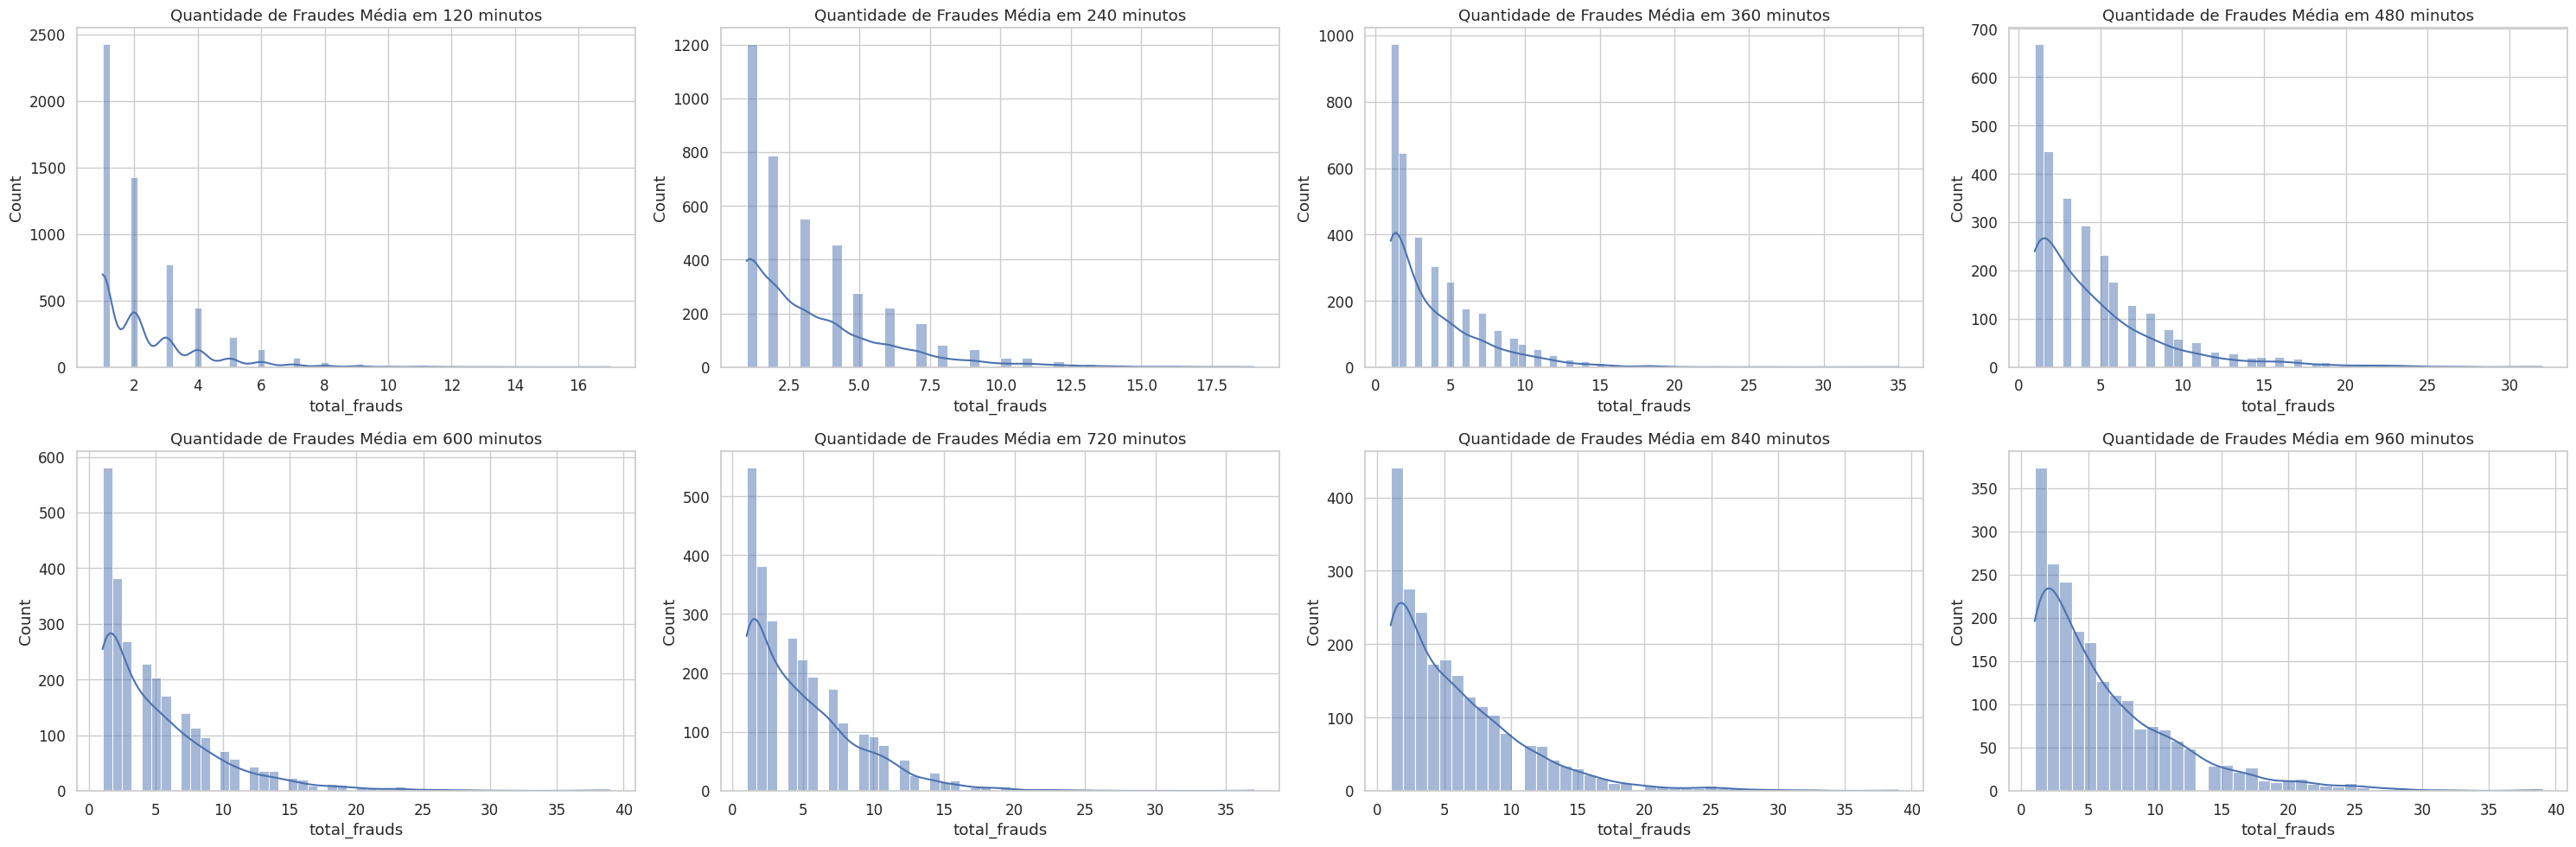

In [19]:
minutes = [120, 240, 360, 480, 600, 720, 840, 960]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))  # Ajuste proporcional ao número de linhas

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

### Validação com modelos dummies

In [20]:
window_data_builder = WindowDataBuilder(df, discretize_numerical=True, discretization_strategy='quantile')

In [21]:
%%time

builders = []

for minute in tqdm(minutes, desc='Validando periodos'):
  df_train, _ = window_data_builder.build(f'{minute}m', False)

  builder = BaselineCoutingModel(df_train, f'{minute}m')
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/8 [00:00<?, ?it/s]

Added 30 discretized numerical features
Training BASELINE Poisson with window 120m
Training BASELINE Binomial Negativa with window 120m
Training BASELINE ZIP with window 120m
Training BASELINE ZINB with window 120m
Baseline Models Trained
Added 30 discretized numerical features
Training BASELINE Poisson with window 240m
Training BASELINE Binomial Negativa with window 240m
Training BASELINE ZIP with window 240m
Training BASELINE ZINB with window 240m
Baseline Models Trained
Added 30 discretized numerical features
Training BASELINE Poisson with window 360m
Training BASELINE Binomial Negativa with window 360m
Training BASELINE ZIP with window 360m
Training BASELINE ZINB with window 360m
Baseline Models Trained
Added 30 discretized numerical features
Training BASELINE Poisson with window 480m
Training BASELINE Binomial Negativa with window 480m
Training BASELINE ZIP with window 480m
Training BASELINE ZINB with window 480m
Baseline Models Trained
Added 30 discretized numerical features
Trai

In [22]:
df_report = pd.concat(list(map(lambda x: x.get_report(), builders)))
df_report.sort_values(by=['LLF'], inplace=True, ascending=True)
df_report.reset_index(drop=True, inplace=True)
df_report

window         model_name           LLF            BIC           AIC  \
0    120m            Poisson -36275.989978 -401476.505294  72553.979957   
1    240m            Poisson -30834.448708 -164396.332806  61670.897415   
2    360m            Poisson -27660.577424  -91977.371342  55323.154848   
3    120m                ZIP -26063.865354   52149.072336  52131.730708   
4    480m            Poisson -26022.811243  -56552.589144  52047.622487   
5    120m  Binomial Negativa -25578.112367   51177.566362  51160.224734   
6    120m               ZINB -25466.768546   50965.549534  50939.537092   
7    600m            Poisson -24094.193406  -37902.607411  48190.386812   
8    840m            Poisson -20865.122440  -19295.304037  41732.244881   
9    720m            Poisson -20782.606047  -30500.028095  41567.212094   
10   960m            Poisson -19912.276693  -13436.164987  39826.553386   
11   240m                ZIP -19059.576801   38139.109215  38123.153602   
12   240m  Binomial Negativa -18325.771548   36671.498708  36655.543095   
13   360m                ZIP -16725.600643   33470.346108  33455.201286   
14   360m  Binomial Negativa -15278.393713   30575.932248  30560.787427   
15   360m               ZINB -15181.642171   30392.001575  30369.284343   
16   480m                ZIP -14828.850738   29676.271073  29661.701477   
17   600m                ZIP -13613.005337   27244.134123  27230.010674   
18   480m  Binomial Negativa -13003.024727   26024.619051  26010.049455   
19   480m               ZINB -12888.973902   25805.802199  25783.947804   
20   720m                ZIP -12557.508700   25132.776067  25119.017400   
21   840m                ZIP -11871.800911   23761.052512  23747.601822   
22   600m  Binomial Negativa -11720.489715   23459.102878  23444.979429   
23   960m                ZIP -11438.067262   22893.318011  22880.134524   
24   720m  Binomial Negativa -11391.654331   22801.067328  22787.308662   
25   720m               ZINB -11214.393221   22455.424442  22434.786443   
26   840m  Binomial Negativa -10103.771434   20224.993559  20211.542869   
27   840m               ZINB  -9967.425454   19961.026943  19940.850908   
28   960m  Binomial Negativa  -9456.677230   18930.537949  18917.354461   
29   960m               ZINB  -9331.161139   18688.097510  18668.322278   
30   240m               ZINB           NaN            NaN           NaN   
31   600m               ZINB           NaN            NaN           NaN   

    Converged      PseudoR2  RMSE_Pearson  Outliers  
0        True  0.000000e+00      1.820342      3183  
1        True -4.440892e-16      2.171920      1940  
2        True  0.000000e+00      2.417296      1736  
3        True -3.307499e-10      1.113875      1756  
4        True -6.661338e-16      2.703076      1328  
5        True  7.790490e-11      0.925692      1756  
6        True -6.807821e-11      1.004906      1756  
7        True  0.000000e+00      2.777699      1309  
8        True  0.000000e+00      2.817431      1100  
9        True  0.000000e+00      2.496118      1148  
10       True -1.332268e-15      2.912284       868  
11       True  4.816858e-11      1.156502      1389  
12       True  1.716665e-10      0.857839       934  
13       True  9.847900e-11      1.233585      1039  
14       True  9.453016e-11      0.867128       605  
15       True -3.338627e-10      0.981013       782  
16       True  9.942958e-11      1.295203       802  
17       True  2.313305e-11      1.304697       706  
18       True  8.660539e-11      0.859188       383  
19       True  1.040112e-11      0.997476       496  
20       True  2.007960e-11      1.238186       559  
21       True -1.043610e-13      1.307395       519  
22       True  4.001544e-11      0.839985       356  
23       True -3.337508e-11      1.342494       453  
24       True  1.536576e-10      0.812383       253  
25       True  4.974909e-11      0.975133       443  
26       True  1.500922e-11      0.811507       212  
27       True -

In [23]:
df_report_filter = df_report[df_report.LLF.notna()].groupby('window').agg(count=('window', 'count'), llf=('LLF', 'median'))
df_report_filter.query('count == 4', inplace=True)
df_report_filter.sort_values(by=['llf'], ascending=False, inplace=True)
df_report_filter.reset_index(inplace=True)
df_report_filter

window  count           llf
0   960m      4 -10447.372246
1   840m      4 -10987.786173
2   720m      4 -11974.581516
3   480m      4 -13915.937733
4   360m      4 -16001.997178
5   120m      4 -25820.988860

### Seleção da melhor janela de tempo

In [24]:
selected_builder = list(filter(lambda x: x.window == df_report_filter.loc[0, 'window'], builders))[0]
selected_builder.get_report()

window         model_name           LLF           BIC           AIC  \
0   960m            Poisson -19912.276693 -13436.164987  39826.553386   
1   960m  Binomial Negativa  -9456.677230  18930.537949  18917.354461   
2   960m                ZIP -11438.067262  22893.318011  22880.134524   
3   960m               ZINB  -9331.161139  18688.097510  18668.322278   

   Converged      PseudoR2  RMSE_Pearson  Outliers  
0       True -1.332268e-15      2.912284       868  
1       True  7.036938e-11      0.817686       200  
2       True -3.337508e-11      1.342494       453  
3       True -4.173122e-10      0.978726       307

#### Visualização da distribuição observada dos eventos X modelo dummy

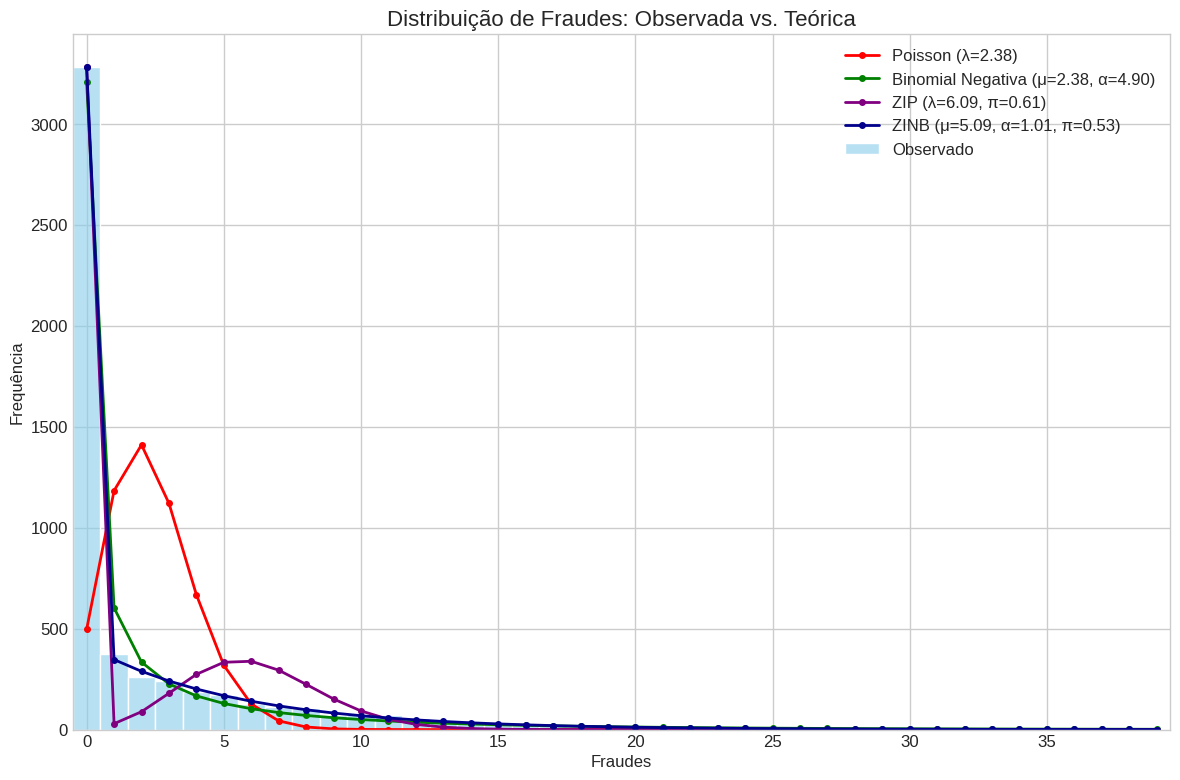

In [25]:
selected_builder.plot_theoretical_distributions()

In [26]:
selected_builder.df.head()

date_window  frauds  transaction_per_client  \
3283 2010-01-01 00:00:00       0                2.010724   
2853 2010-01-01 16:00:00       1                1.661765   
3009 2010-01-02 08:00:00       0                2.003846   
2562 2010-01-03 00:00:00       0                1.985602   
2455 2010-01-03 16:00:00       1                1.607595   

      transaction_per_merchant  target_city_0  target_city_1  target_city_2  \
3283                  2.890173            1.0            0.0            0.0   
2853                  2.365116            1.0            0.0            0.0   
3009                  2.662692            1.0            0.0            0.0   
2562                  2.694494            1.0            0.0            0.0   
2455                  2.484108            1.0            0.0            0.0   

      target_country_0  target_country_1  target_country_2  ...  \
3283               1.0               0.0               0.0  ...   
2853               1.0               0.0               0.0  ...   
3009               1.0               0.0               0.0  ...   
2562               1.0               0.0               0.0  ...   
2455               1.0               0.0               0.0  ...   

      credit_limit_credit_limit_discretized_0  \
3283                                 0.211333   
2853                                 0.218289   
3009                                 0.198976   
2562                                 0.197759   
2455                                 0.221457   

      credit_limit_credit_limit_discretized_1  \
3283                                 0.202667   
2853                                 0.201573   
3009                                 0.226488   
2562                                 0.212920   
2455                                 0.204724   

      credit_limit_credit_limit_discretized_2  \
3283                                 0.186667   
2853                                 0.194690   
3009                                 0.204095   
2562                                 0.195781   
2455                                 0.200787   

      credit_limit_credit_limit_discretized_3  \
3283                                 0.196000   
2853                                 0.194690   
3009                                 0.194498   
2562                                 0.194463   
2455                                 0.194882   

      credit_limit_credit_limit_discretized_4  \
3283                                 0.203333   
2853                                 0.190757   
3009                                 0.175944   
2562                                 0.199077   
2455                                 0.178150   

      current_age_current_age_discretized_0  \
3283                               0.148000   
2853                               0.151426   
3009                               0.150992   
2562                               0.177983   
2455                               0.151575   

      current_age_current_age_discretized_1  \
3283                               0.178667   
2853                               0.192724   
3009                               0.191939   
2562                               0.201714   
2455                               0.216535   

      current_age_current_age_discretized_2  \
3283                               0.224667   
2853                               0.235005   
3009                               0.223928   
2562                               0.206328   
2455                               0.211614   

      current_age_current_age_discretized_3  \
3283                               0.214667   
2853                               0.214356   
3009                               0.219450   
2562                               0.199077   
2455                               0.213583   

      current_age_current_age_discretized_4  
3283                               0.234000  
2853                               0.206490  
3009                         

#### Correlação dos dados no dataframe da janela selecionada

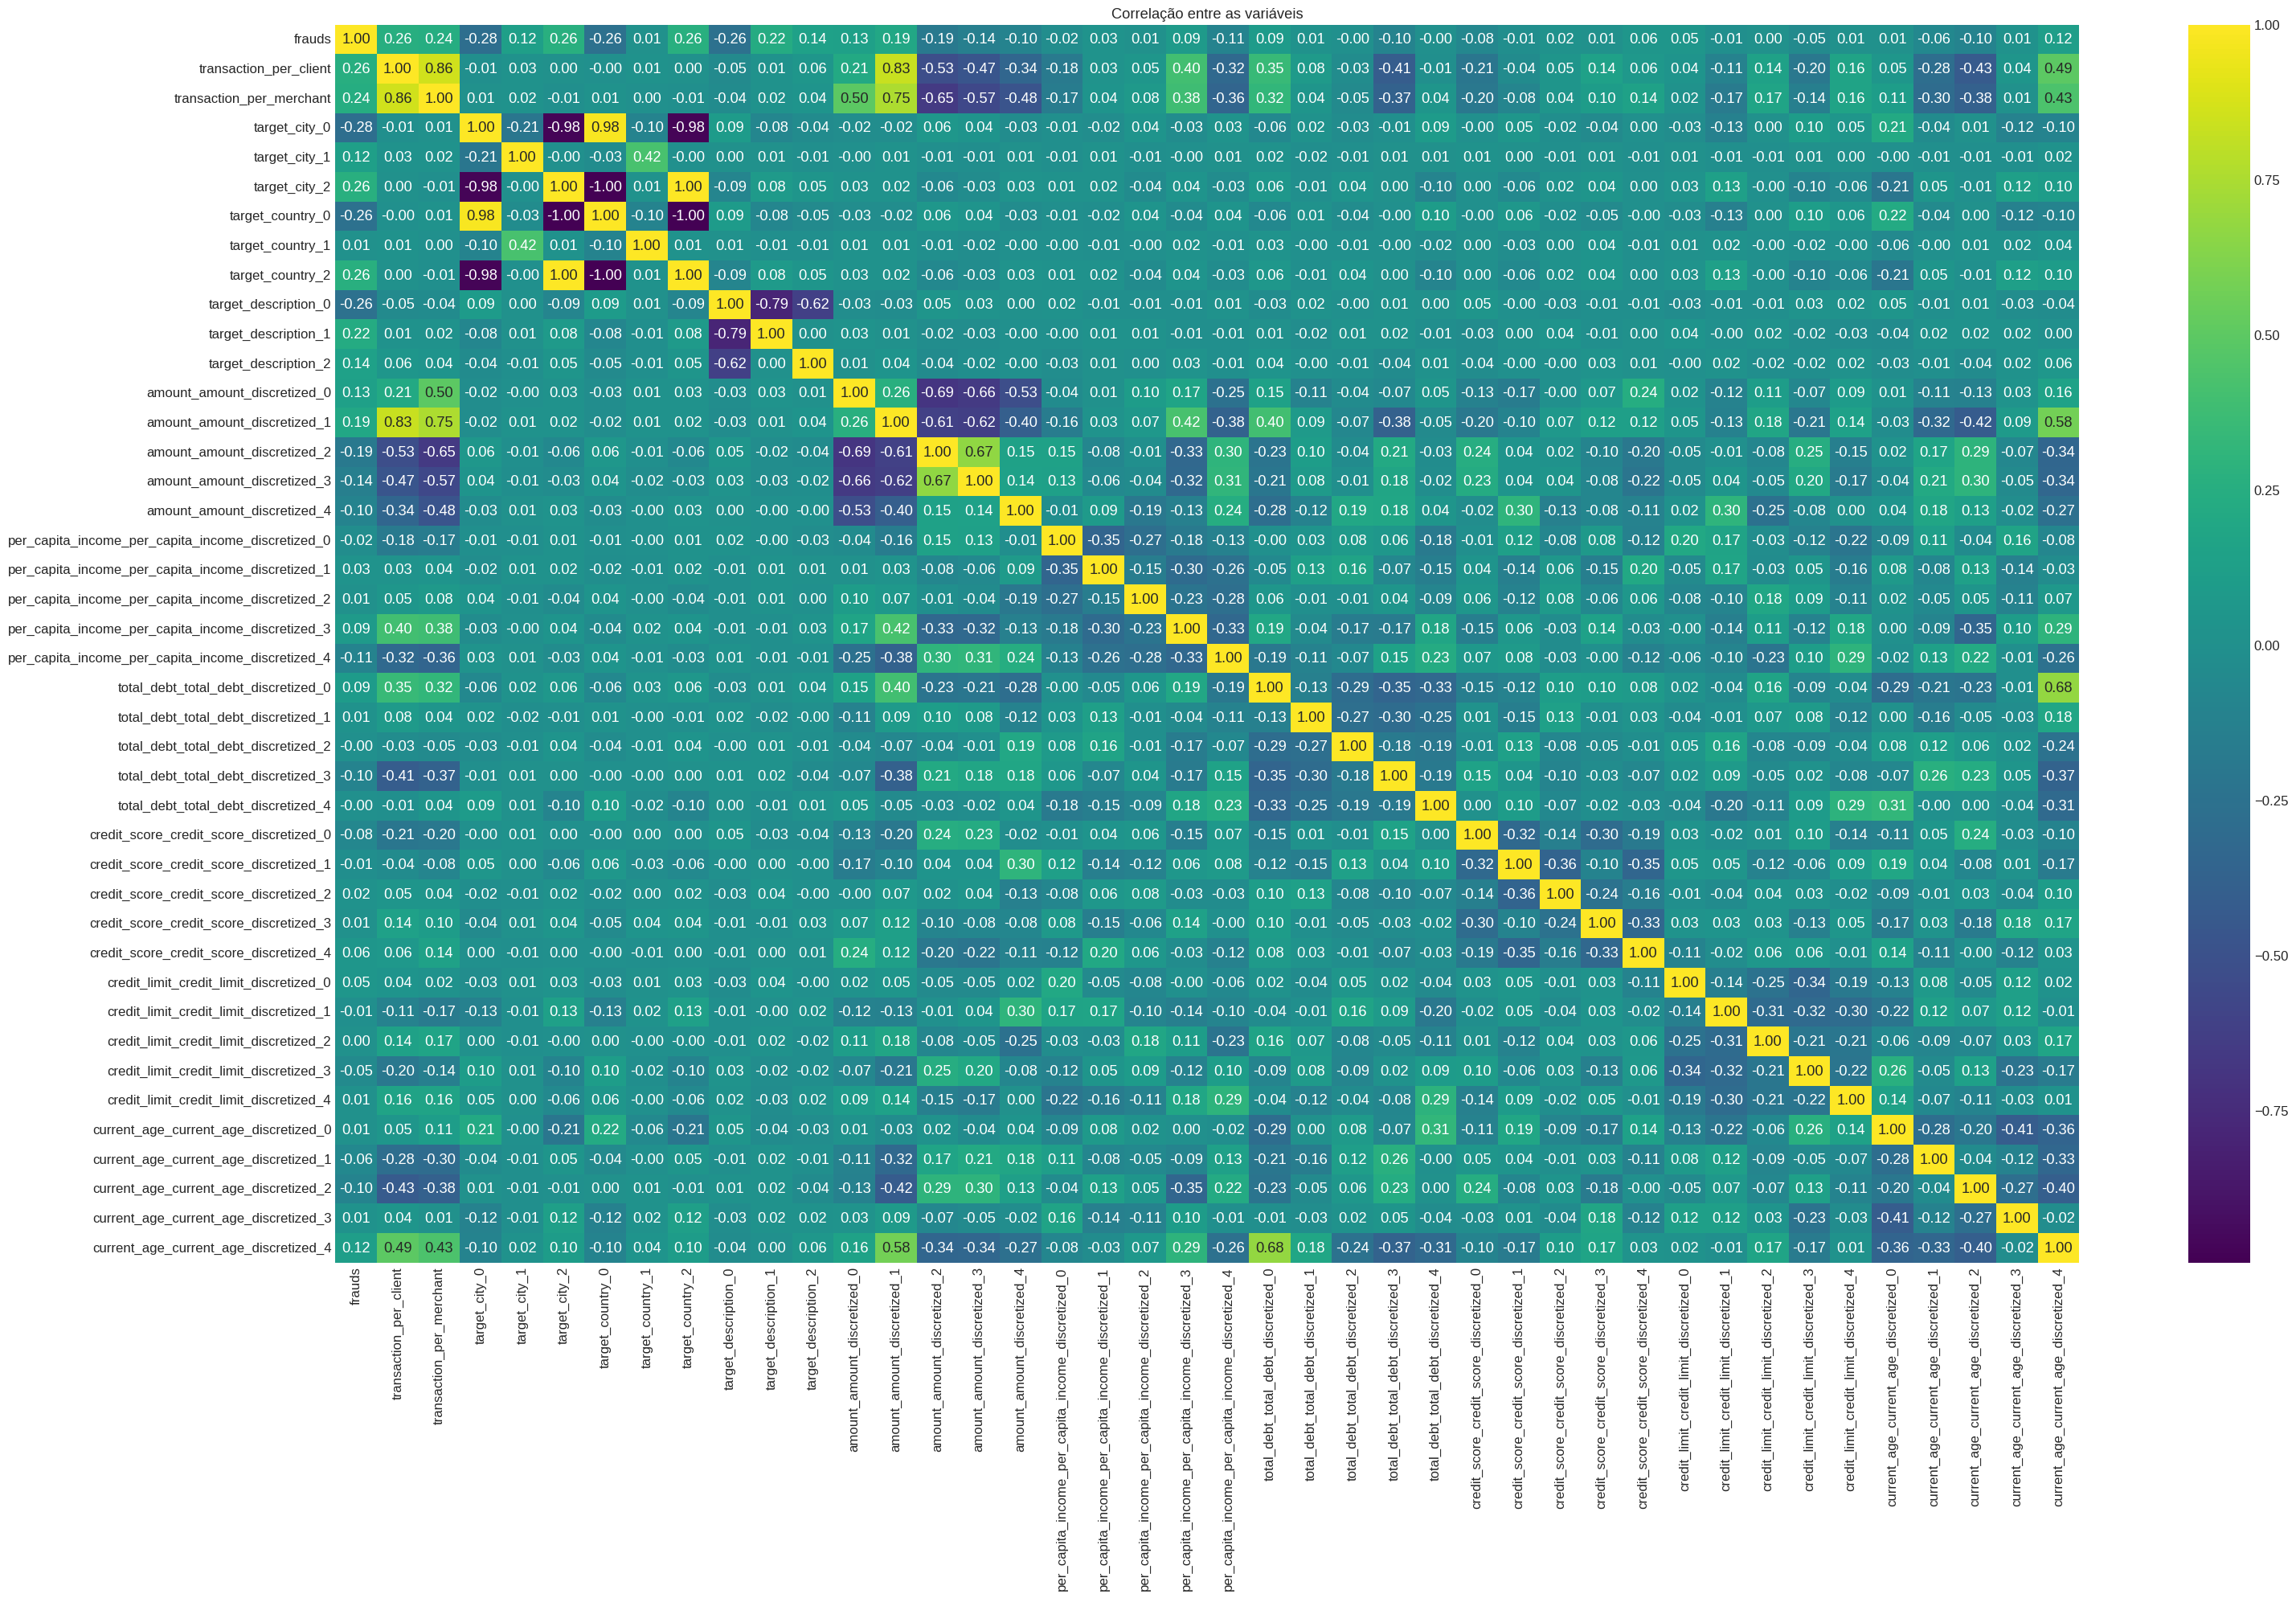

In [27]:
corr = selected_builder.df.corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

#### Correlação do dataframe após removação de variaveis com alta correlação

In [28]:
df_train, map_discretizer = window_data_builder.build(selected_builder.window, True)
selected_builder = BaselineCoutingModel(df_train, selected_builder.window)
builder.train()

Added 30 discretized numerical features
Removed 6 highly correlated features
Columns removed: target_country_2, amount_amount_discretized_1, target_description_1, transaction_per_merchant, target_city_2, target_country_0
Training BASELINE Poisson with window 960m
Training BASELINE Binomial Negativa with window 960m
Training BASELINE ZIP with window 960m
Training BASELINE ZINB with window 960m
Baseline Models Trained


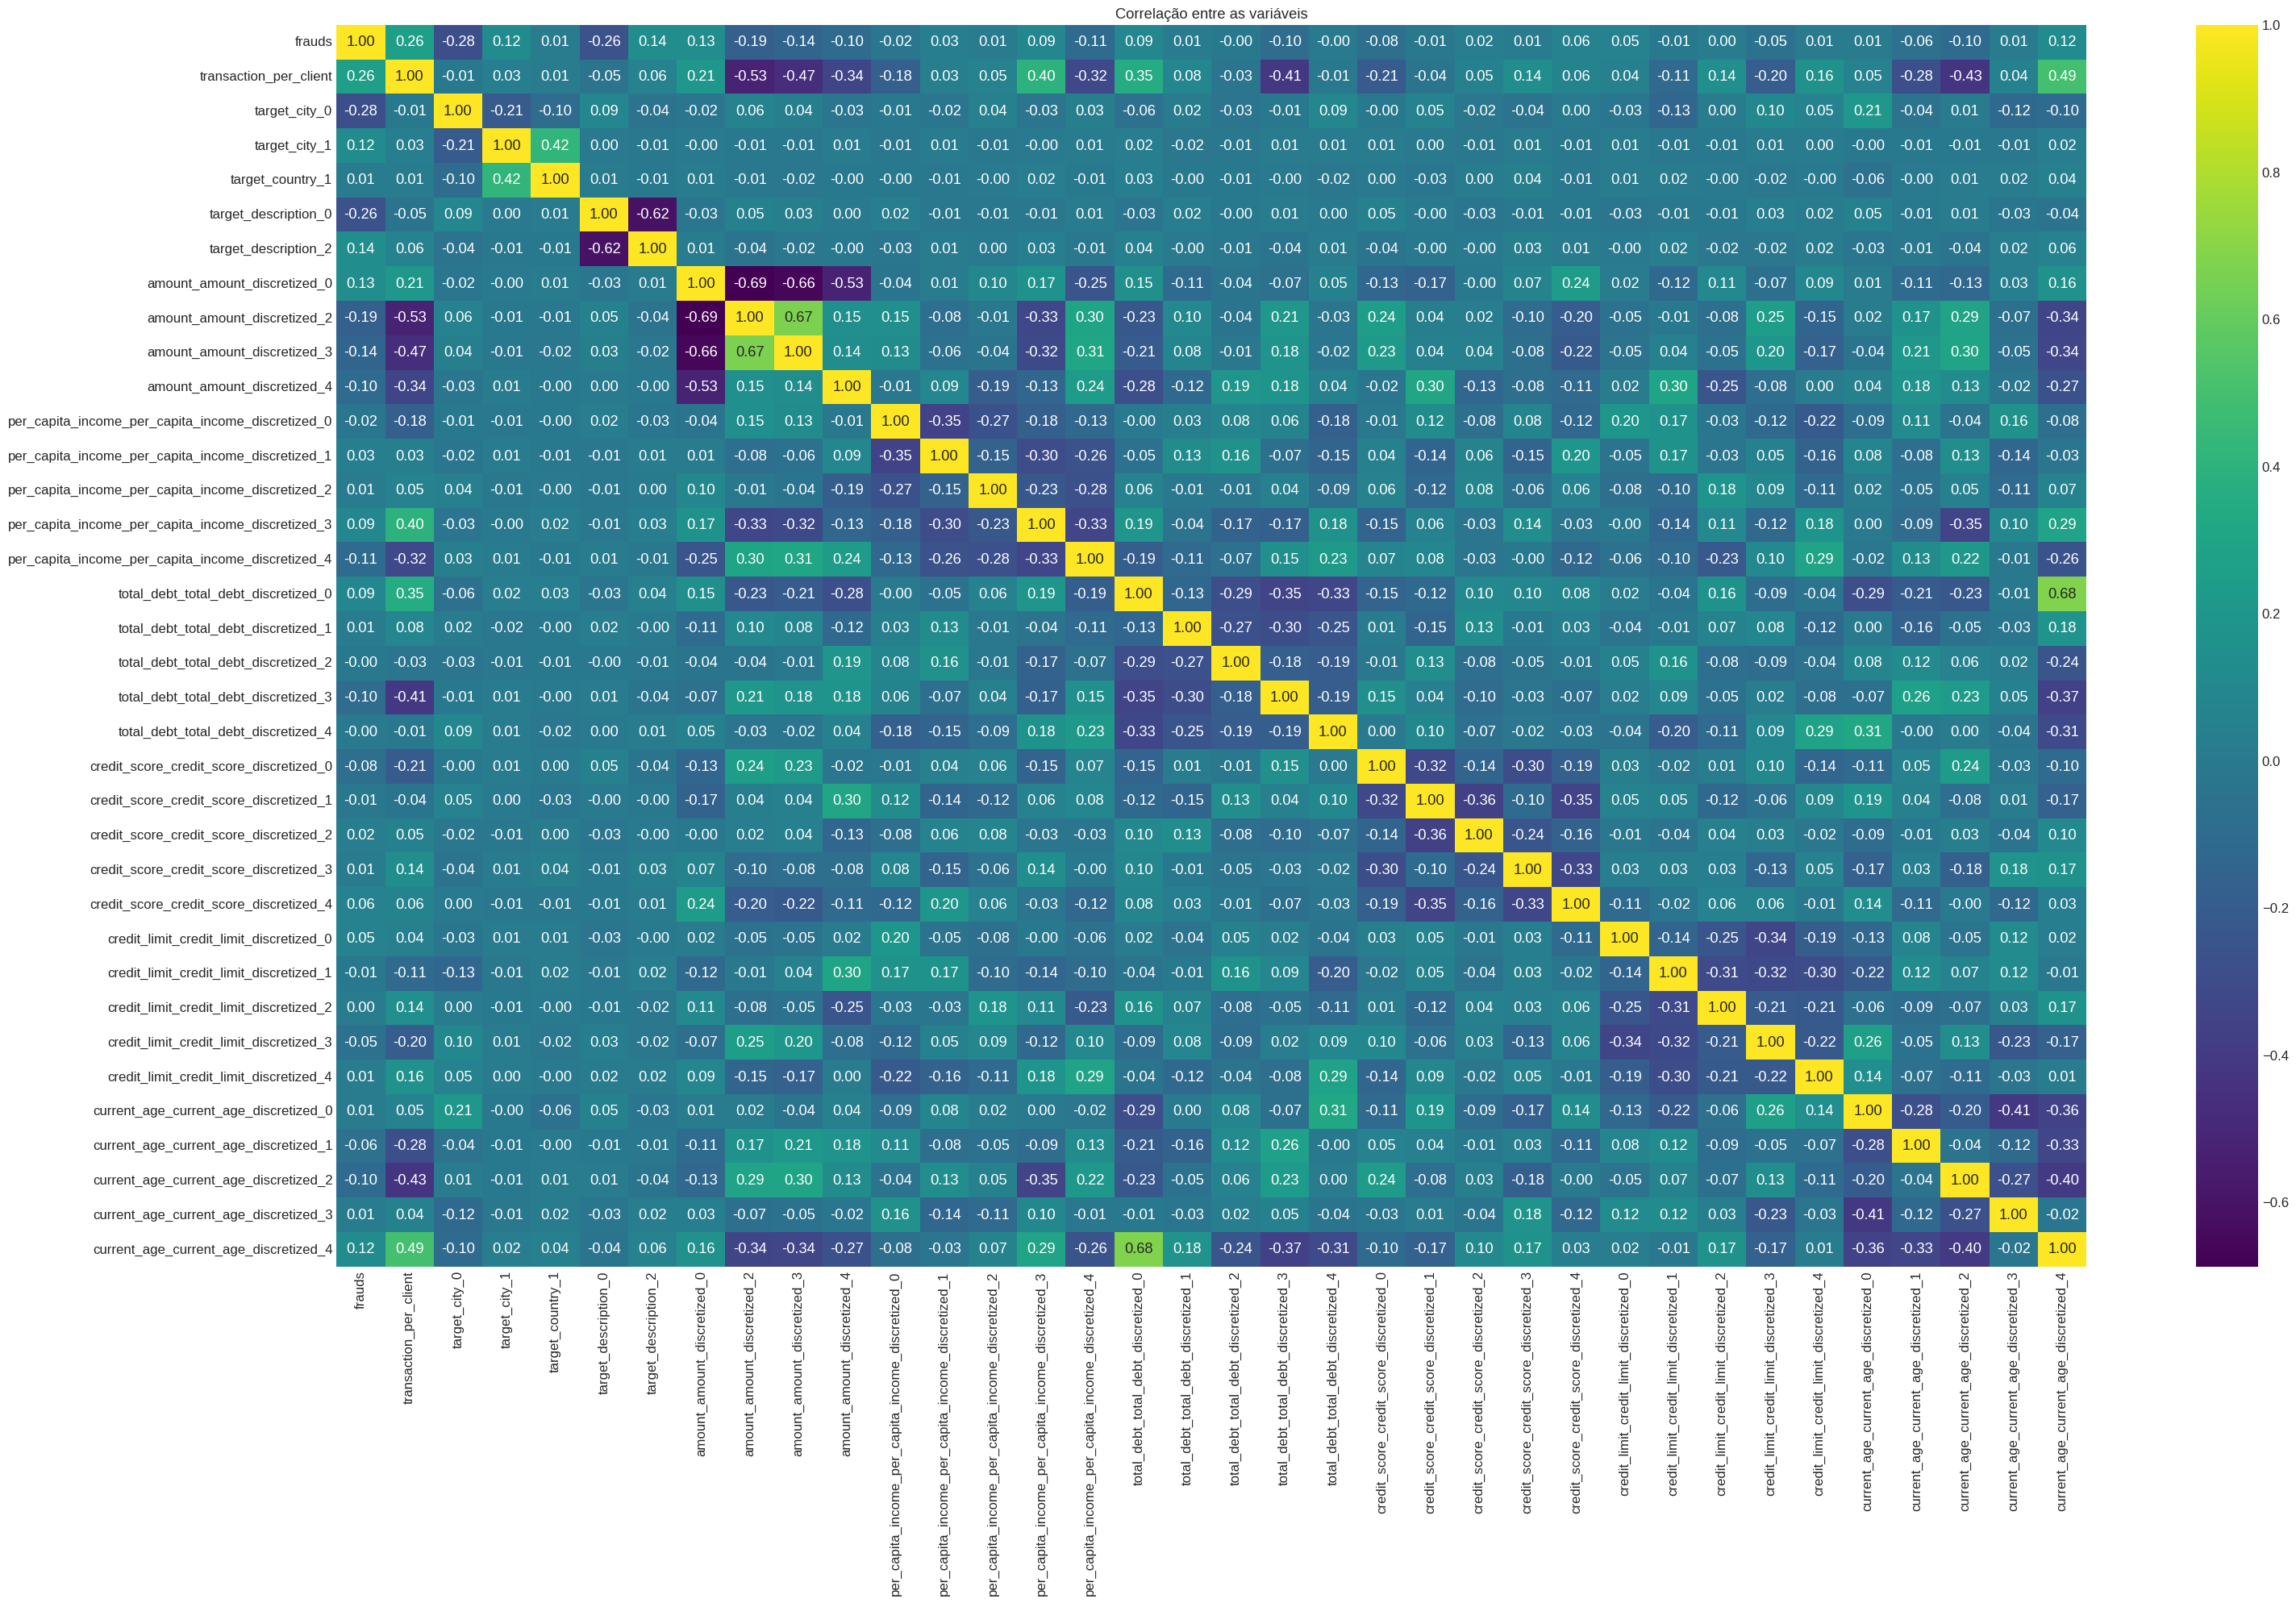

In [29]:
corr = selected_builder.df.corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Modelagem

In [30]:
X = selected_builder.df.drop(columns=['date_window']).copy()
y = X['frauds']

In [31]:
X.describe().T

count          mean  \
frauds                                             5387.0  2.383887e+00   
transaction_per_client                             5387.0  1.926992e+00   
target_city_0                                      5387.0  9.999643e-01   
target_city_1                                      5387.0  3.073342e-06   
target_country_1                                   5387.0  5.816572e-07   
target_description_0                               5387.0  9.999452e-01   
target_description_2                               5387.0  2.266548e-05   
amount_amount_discretized_0                        5387.0  1.982246e-01   
amount_amount_discretized_2                        5387.0  2.026981e-01   
amount_amount_discretized_3                        5387.0  2.024126e-01   
amount_amount_discretized_4                        5387.0  2.018708e-01   
per_capita_income_per_capita_income_discretized_0  5387.0  2.003302e-01   
per_capita_income_per_capita_income_discretized_1  5387.0  1.997576e-01   
per_capita_income_per_capita_income_discretized_2  5387.0  1.994009e-01   
per_capita_income_per_capita_income_discretized_3  5387.0  1.989446e-01   
per_capita_income_per_capita_income_discretized_4  5387.0  2.015668e-01   
total_debt_total_debt_discretized_0                5387.0  1.988131e-01   
total_debt_total_debt_discretized_1                5387.0  2.000148e-01   
total_debt_total_debt_discretized_2                5387.0  1.997935e-01   
total_debt_total_debt_discretized_3                5387.0  2.011532e-01   
total_debt_total_debt_discretized_4                5387.0  2.002254e-01   
credit_score_credit_score_discretized_0            5387.0  1.997996e-01   
credit_score_credit_score_discretized_1            5387.0  1.993379e-01   
credit_score_credit_score_discretized_2            5387.0  1.985664e-01   
credit_score_credit_score_discretized_3            5387.0  1.976163e-01   
credit_score_credit_score_discretized_4            5387.0  2.046798e-01   
credit_limit_credit_limit_discretized_0            5387.0  1.998008e-01   
credit_limit_credit_limit_discretized_1            5387.0  2.002928e-01   
credit_limit_credit_limit_discretized_2            5387.0  1.997876e-01   
credit_limit_credit_limit_discretized_3            5387.0  2.004939e-01   
credit_limit_credit_limit_discretized_4            5387.0  1.996250e-01   
current_age_current_age_discretized_0              5387.0  1.894581e-01   
current_age_current_age_discretized_1              5387.0  1.948329e-01   
current_age_current_age_discretized_2              5387.0  2.015274e-01   
current_age_current_age_discretized_3              5387.0  2.074759e-01   
current_age_current_age_discretized_4              5387.0  2.067057e-01   

                                                        std       min  \
frauds                                             4.496938  0.000000   
transaction_per_client                             0.221851  1.000000   
target_city_0                                      0.000212  0.995633   
target_city_1                                      0.000046  0.000000   
target_country_1                                   0.000019  0.000000   
target_description_0                               0.000197  0.997971   
target_description_2                               0.000121  0.000000   
amount_amount_discretized_0                        0.034210  0.000000   
amount_amount_discretized_2                        0.022260  0.000000   
amount_amount_discretized_3                        0.021389  0.000000   
amount_amount_discretized_4                        0.022612  0.138462   
per_capita_income_per_capita_income_discretized_0  0.010446  0.000000   
per_capita_income_per_capita_income_discretized_1  0.011656  0.000000   
per_capita_income_per_capita_income_discretized_2  0.010321  0.000000   
per_capita_income_per_capita_income_discretized_3  0.011503  0.000000   
per_capita_income_per_capita_income_discretized_4  0.011010  0.161964   
total_debt_total_debt_discretized_0

In [32]:
y.value_counts()

frauds
0     3283
1      374
2      263
3      242
4      185
5      172
6      127
7      111
8      105
10      75
9       72
11      71
12      58
13      49
15      30
14      29
17      27
16      22
21      14
20      13
18      12
19      10
25       9
22       8
23       6
24       5
28       4
26       4
27       2
29       1
32       1
39       1
38       1
31       1
Name: count, dtype: int64

### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.


#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [33]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  2.383887  20.222451

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

#### Implementação dos modelos

##### Completo

In [34]:
formula = "frauds ~ " + ' + '.join(X.drop(columns=['frauds']).columns)
formula

'frauds ~ transaction_per_client + target_city_0 + target_city_1 + target_country_1 + target_description_0 + target_description_2 + amount_amount_discretized_0 + amount_amount_discretized_2 + amount_amount_discretized_3 + amount_amount_discretized_4 + per_capita_income_per_capita_income_discretized_0 + per_capita_income_per_capita_income_discretized_1 + per_capita_income_per_capita_income_discretized_2 + per_capita_income_per_capita_income_discretized_3 + per_capita_income_per_capita_income_discretized_4 + total_debt_total_debt_discretized_0 + total_debt_total_debt_discretized_1 + total_debt_total_debt_discretized_2 + total_debt_total_debt_discretized_3 + total_debt_total_debt_discretized_4 + credit_score_credit_score_discretized_0 + credit_score_credit_score_discretized_1 + credit_score_credit_score_discretized_2 + credit_score_credit_score_discretized_3 + credit_score_credit_score_discretized_4 + credit_limit_credit_limit_discretized_0 + credit_limit_credit_limit_discretized_1 + cred

In [35]:
modelo_poisson  = smf.glm(formula=formula, data=X, family=sm.families.Poisson()).fit()

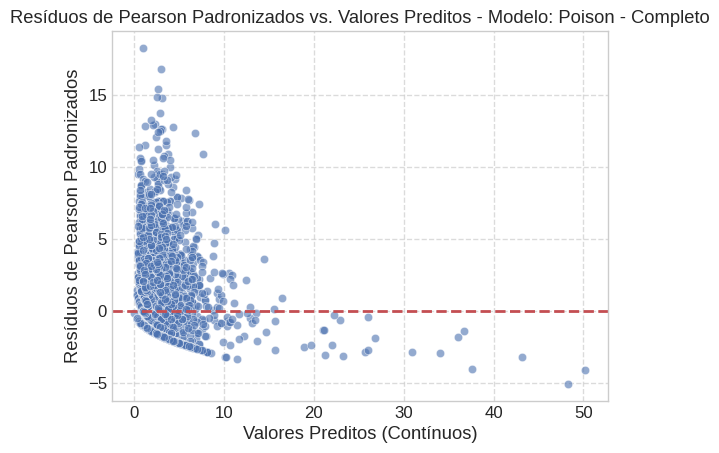

In [36]:
overdisp_plot(modelo_poisson, 'Poison - Completo')

In [101]:
diagnosticar_dispersao_ct(modelo_poisson, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(30.52024786244118),
 'p_valor': np.float64(7.739822872865094e-189)}

O gráfico acima demonstra como o modelo tem dificuldade para prever os valores. O um padrão de funil no dados demonstra que o presuposto de equidispersão não foi atendido, e a variância dos resíduos não é constante em relação à média prevista, sendo muito maior para contagens baixas.

In [37]:
overdisp(modelo_poisson, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.069     
Dependent Variable:     ystar            AIC:                         44580.9619
Date:                   2025-08-19 11:07 BIC:                         44587.5537
No. Observations:       5387             Log-Likelihood:              -22289.   
Df Model:               1                F-statistic:                 400.7     
Df Residuals:           5386             Prob (F-statistic):          4.96e-86  
R-squared (uncentered): 0.069            Scale:                       229.89    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.2125         0.0606       20.0167       0.0000       1.0938       1.3313
--

O teste evidencia o ponto já validado inicialmente do presuposto. O modelo não atende a capacidade de overdispersion.

##### Stepwise

In [38]:
modelo_poisson_stepwise = stepwise(modelo_poisson, pvalue_limit=0.05)
modelo_poisson_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transaction_per_client') + Q('target_city_0') + Q('target_city_1') + Q('target_country_1') + Q('target_description_0') + Q('target_description_2') + Q('amount_amount_discretized_0') + Q('amount_amount_discretized_2') + Q('amount_amount_discretized_3') + Q('amount_amount_discretized_4') + Q('per_capita_income_per_capita_income_discretized_0') + Q('per_capita_income_per_capita_income_discretized_1') + Q('per_capita_income_per_capita_income_discretized_2') + Q('per_capita_income_per_capita_income_discretized_3') + Q('per_capita_income_per_capita_income_discretized_4') + Q('total_debt_total_debt_discretized_0') + Q('total_debt_total_debt_discretized_1') + Q('total_debt_total_debt_discretized_2') + Q('total_debt_total_debt_discretized_3') + Q('total_debt_total_debt_discretized_4') + Q('credit_score_credit_score_discretized_0') + Q('credit_score_credit_score_discretized_1') + Q('credit_score_credit_score_discretized_2') + Q('credit_sc

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 5387
Model:                            GLM   Df Residuals:                     5356
Model Family:                 Poisson   Df Model:                           30
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -16131.
Date:                Tue, 19 Aug 2025   Deviance:                       25277.
Time:                        11:07:31   Pearson chi2:                 3.08e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.7543
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               1066.0016     18.429     57.845      0.000    1029.882    1102.121
Q('transaction_per_client')                                3.1647      0.083     38.124      0.000       3.002       3.327
Q('target_city_0')                                      -882.6858     20.313    -43.454      0.000    -922.499    -842.873
Q('target_city_1')                                      1173.2830     93.906     12.494      0.000     989.231    1357.334
Q('target_country_1')                                  -1095.3545    387.556     -2.826      0.005   -1854.950    -335.759
Q('target_description_0')                              -1260.7750     32.902    -38.319      0.000   -1325.261   -1196.289
Q('target_description_2')                               -162.4946     59.968     -2.710      0.007    -280.029     -44.960
Q('amount_amount_discretized_0')                          11.3148      0.839     13.483      0.000       9.670      12.960
Q('amount_amount_discretized_2')                           3.0310      0.987      3.071      0.002       1.096       4.966
Q('amount_amount_discretized_3')                           8.9968      0.875     10.286      0.000       7.282      10.711
Q('amount_amount_discretized_4')                           6.0667      0.908      6.681      0.000       4.287       7.846
Q('per_capita_income_per_capita_income_discretized_0')   216.9436      3.818     56.825      0.000     209.461     224.426
Q('per_capita_income_per_capita_income_discretized_1')   213.3085      3.730     57.191      0.000     205.998     220.619
Q('per_capita_income_per_capita_income_discretized_2')   213.0043      3.767     56.549      0.000     205.622     220.387
Q('per_capita_income_per_capita_income_discretized_3')   210.7515      3.751     56.181      0.000     203.399     218.104
Q('per_capita_income_per_capita_income_discretized_4')   211.9937      3.802     55.756      0.000     204.541     219.446
Q('total_debt_total_debt_discretized_0')                 214.4932      3.829     56.016      0.000     206.988     221.998
Q('total_debt_total_debt_discretized_1')                 215.2688      3.800     56.653      0.000     207.821     222.716
Q('total_debt_total_debt_discretized_2')                 210.3066      3.736     56.293      0.000     202.984     217.629
Q('total_debt_total_debt_discretized_3')                 211.4632      3.754     56.337      0.000     204.106     218.820
Q('total_debt_total_debt_discretized_4')                 214.4698      3.786     56.646      0.000     207.049     221.891
Q('credit_score_credit_score_discretized_0')             211.5646      3.807     55.577      0.000     204.104     219.026
Q('credi

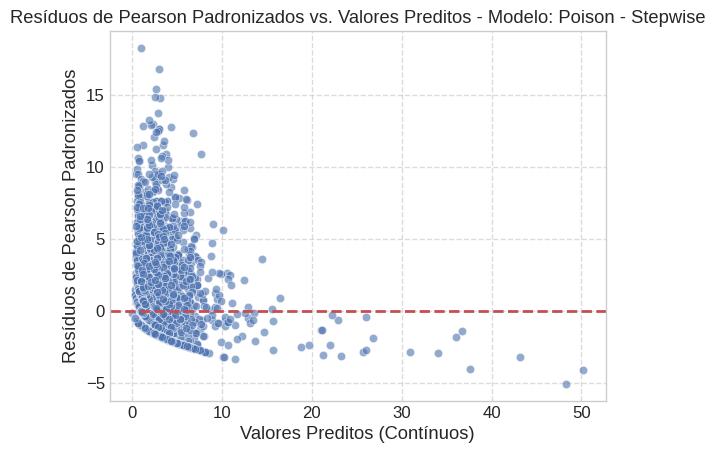

In [39]:
overdisp_plot(modelo_poisson_stepwise, 'Poison - Stepwise')

In [100]:
diagnosticar_dispersao_ct(modelo_poisson_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(30.52024786244118),
 'p_valor': np.float64(7.739822872865094e-189)}

O gráfico apresenta o mesmo problema relatado no modelo completo, não atendendo o critério de equidispersão.

In [40]:
overdisp(modelo_poisson_stepwise, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.069     
Dependent Variable:     ystar            AIC:                         44580.9619
Date:                   2025-08-19 11:07 BIC:                         44587.5537
No. Observations:       5387             Log-Likelihood:              -22289.   
Df Model:               1                F-statistic:                 400.7     
Df Residuals:           5386             Prob (F-statistic):          4.96e-86  
R-squared (uncentered): 0.069            Scale:                       229.89    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.2125         0.0606       20.0167       0.0000       1.0938       1.3313
--

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância maior que a média.

In [41]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  2.383887  20.222451

#### Implementação dos modelos

##### Completo

In [42]:
modelo_binomial = smf.glm(formula=formula, data=X, family=sm.families.NegativeBinomial()).fit()
modelo_binomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 5387
Model:                            GLM   Df Residuals:                     5356
Model Family:        NegativeBinomial   Df Model:                           30
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9988.7
Date:                Tue, 19 Aug 2025   Deviance:                       9141.7
Time:                        11:07:33   Pearson chi2:                 1.04e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.3295
Covariance Type:            nonrobust                                         
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
Intercept                                          1502.0556     58.435     25.705      0.000    1387.525    1616.587
transaction_per_client                                3.1195      0.153     20.361      0.000       2.819       3.420
target_city_0                                     -1489.6857     72.831    -20.454      0.000   -1632.432   -1346.939
target_city_1                                       954.9123    351.325      2.718      0.007     266.329    1643.496
target_country_1                                  -1228.2373    884.724     -1.388      0.165   -2962.265     505.791
target_description_0                              -1525.8237     96.531    -15.807      0.000   -1715.021   -1336.627
target_description_2                               -308.8639    159.452     -1.937      0.053    -621.383       3.655
amount_amount_discretized_0                          11.4110      1.524      7.490      0.000       8.425      14.397
amount_amount_discretized_2                           4.4307      1.807      2.452      0.014       0.890       7.972
amount_amount_discretized_3                           8.6600      1.607      5.389      0.000       5.510      11.810
amount_amount_discretized_4                           4.7577      1.705      2.790      0.005       1.415       8.100
per_capita_income_per_capita_income_discretized_0   303.8413     11.834     25.676      0.000     280.648     327.035
per_capita_income_per_capita_income_discretized_1   300.8815     11.756     25.593      0.000     277.840     323.924
per_capita_income_per_capita_income_discretized_2   299.9887     11.798     25.426      0.000     276.864     323.113
per_capita_income_per_capita_income_discretized_3   295.9802     11.749     25.193      0.000     272.953     319.007
per_capita_income_per_capita_income_discretized_4   301.3639     11.791     25.558      0.000     278.253     324.475
total_debt_total_debt_discretized_0                 301.6820     11.850     25.459      0.000     278.457     324.907
total_debt_total_debt_discretized_1                 302.7389     11.826     25.600      0.000     279.561     325.917
total_debt_total_debt_discretized_2                 295.1632     11.728     25.167      0.000     272.177     318.150
total_debt_total_debt_discretized_3                 299.1123     11.753     25.451      0.000     276.078     322.147
total_debt_total_debt_discretized_4                 303.3592     11.819     25.666      0.000     280.194     326.525
credit_score_credit_score_discretized_0             298.3595     11.849     25.179      0.000     275.135     321.584
credit_score_credit_score_discretized_1             300.7058     11.771     25.546      0.000     277.635     323.777
credit_score_cr

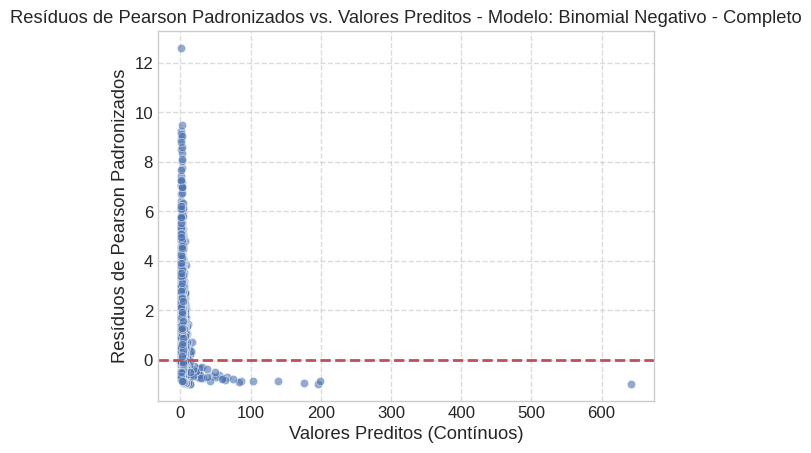

In [43]:
overdisp_plot(modelo_binomial, 'Binomial Negativo - Completo')

In [99]:
diagnosticar_dispersao_ct(modelo_binomial, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(2430.5000371603405), 'p_valor': np.float64(0.0)}

O gráfico de dispersão de residuos demonstra que o modelo conseguiu capturar melhor a relação dos dados uma vez que o presuposto do modelo foi atendido. No entanto nota-se que o modelo teve um problema com outlier, indicando que algum comportamento não foi corretamente mapeado. A alta concentração no eixo vertical proximo a zero pode indicar que o modelo esteja tendo dificuldades para identificar quando a classificação seja realmente um zero estrutural.

##### Stepwise

In [44]:
modelo_binomial_stepwise = stepwise(modelo_binomial, pvalue_limit=0.05)
modelo_binomial_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('transaction_per_client') + Q('target_city_0') + Q('target_city_1') + Q('target_country_1') + Q('target_description_0') + Q('target_description_2') + Q('amount_amount_discretized_0') + Q('amount_amount_discretized_2') + Q('amount_amount_discretized_3') + Q('amount_amount_discretized_4') + Q('per_capita_income_per_capita_income_discretized_0') + Q('per_capita_income_per_capita_income_discretized_1') + Q('per_capita_income_per_capita_income_discretized_2') + Q('per_capita_income_per_capita_income_discretized_3') + Q('per_capita_income_per_capita_income_discretized_4') + Q('total_debt_total_debt_discretized_0') + Q('total_debt_total_debt_discretized_1') + Q('total_debt_total_debt_discretized_2') + Q('total_debt_total_debt_discretized_3') + Q('total_debt_total_debt_discretized_4') + Q('credit_score_credit_score_discretized_0') + Q('credit_score_credit_score_discretized_1') + Q('credit_score_credit_score_discretized_2') + Q('credit_sc

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 5387
Model:                            GLM   Df Residuals:                     5358
Model Family:        NegativeBinomial   Df Model:                           28
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -9991.3
Date:                Tue, 19 Aug 2025   Deviance:                       9146.9
Time:                        11:07:36   Pearson chi2:                 1.04e+04
No. Iterations:                   100   Pseudo R-squ. (CS):             0.3288
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                               1443.4339     51.034     28.284      0.000    1343.408    1543.459
Q('transaction_per_client')                                3.1257      0.153     20.389      0.000       2.825       3.426
Q('target_city_0')                                     -1493.1382     72.831    -20.501      0.000   -1635.884   -1350.392
Q('target_city_1')                                       789.7354    323.249      2.443      0.015     156.180    1423.291
Q('target_description_0')                              -1405.1590     77.100    -18.225      0.000   -1556.272   -1254.045
Q('amount_amount_discretized_0')                          11.4638      1.524      7.520      0.000       8.476      14.452
Q('amount_amount_discretized_2')                           4.4597      1.807      2.468      0.014       0.918       8.002
Q('amount_amount_discretized_3')                           8.6234      1.607      5.365      0.000       5.473      11.773
Q('amount_amount_discretized_4')                           4.8133      1.705      2.823      0.005       1.471       8.155
Q('per_capita_income_per_capita_income_discretized_0')   292.2288     10.379     28.155      0.000     271.886     312.572
Q('per_capita_income_per_capita_income_discretized_1')   289.1511     10.284     28.118      0.000     268.996     309.307
Q('per_capita_income_per_capita_income_discretized_2')   288.2616     10.332     27.900      0.000     268.011     308.512
Q('per_capita_income_per_capita_income_discretized_3')   284.1273     10.271     27.662      0.000     263.996     304.259
Q('per_capita_income_per_capita_income_discretized_4')   289.6652     10.333     28.034      0.000     269.414     309.917
Q('total_debt_total_debt_discretized_0')                 289.9319     10.395     27.891      0.000     269.558     310.306
Q('total_debt_total_debt_discretized_1')                 290.9923     10.363     28.079      0.000     270.680     311.304
Q('total_debt_total_debt_discretized_2')                 283.4213     10.259     27.627      0.000     263.314     303.528
Q('total_debt_total_debt_discretized_3')                 287.5050     10.299     27.916      0.000     267.320     307.690
Q('total_debt_total_debt_discretized_4')                 291.5834     10.336     28.209      0.000     271.324     311.842
Q('credit_score_credit_score_discretized_0')             286.6671     10.385     27.603      0.000     266.312     307.022
Q('credit_score_credit_score_discretized_1')             289.0157     10.310     28.032      0.000     268.808     309.224
Q('credit_score_credit_score_discretized_2')             289.5649     10.274     28.185      0.000     269.429     309.701
Q('credi

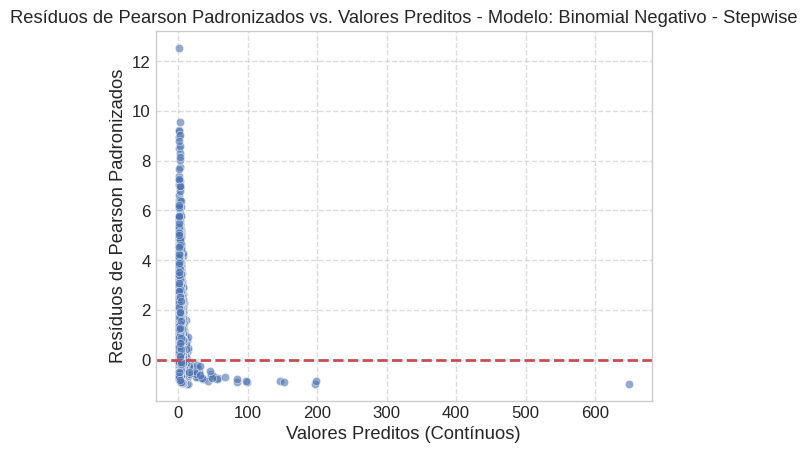

In [45]:
overdisp_plot(modelo_binomial_stepwise, 'Binomial Negativo - Stepwise')

In [98]:
diagnosticar_dispersao_ct(modelo_binomial, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(2430.5000371603405), 'p_valor': np.float64(0.0)}

O modelo stepwise apresenta o mesmo comportamento em relação ao modelo completo.

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.

#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [46]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  2.383887  20.222451

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

##### Completo

In [47]:
X1 = X.drop(columns=['frauds']).copy()
X1 = sm.add_constant(X1)

In [49]:
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1).fit(disp=False,  method='bfgs', cov_type='HC1')
modelo_zip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 5387
Model:             ZeroInflatedPoisson   Df Residuals:                     5356
Method:                            MLE   Df Model:                           30
Date:                 Tue, 19 Aug 2025   Pseudo R-squ.:                  0.1001
Time:                         11:11:48   Log-Likelihood:                -10293.
converged:                       False   LL-Null:                       -11438.
Covariance Type:                   HC1   LLR p-value:                     0.000
=============================================================================================================================
                                                                coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
inflate_const                                                 0.1050   3.64e+09   2.89e-11      1.000   -7.12e+09    7.12e+09
inflate_transaction_per_client                               -0.2415      0.246     -0.984      0.325      -0.723       0.240
inflate_target_city_0                                         0.1325    164.602      0.001      0.999    -322.482     322.747
inflate_target_city_1                                         0.0976    977.012   9.98e-05      1.000   -1914.810    1915.006
inflate_target_country_1                                      0.0995   2607.795   3.82e-05      1.000   -5111.086    5111.285
inflate_target_description_0                                  0.1272    218.985      0.001      1.000    -429.075     429.329
inflate_target_description_2                                  0.0932    337.460      0.000      1.000    -661.317     661.503
inflate_amount_amount_discretized_0                          -1.5605      2.395     -0.652      0.515      -6.255       3.134
inflate_amount_amount_discretized_2                           0.7723      2.856      0.270      0.787      -4.825       6.370
inflate_amount_amount_discretized_3                           0.2016      2.579      0.078      0.938      -4.853       5.256
inflate_amount_amount_discretized_4                           0.5373      2.718      0.198      0.843      -4.791       5.865
inflate_per_capita_income_per_capita_income_discretized_0    -0.0152   1.71e+10   -8.9e-13      1.000   -3.36e+10    3.36e+10
inflate_per_capita_income_per_capita_income_discretized_1    -0.1293   1.71e+10  -7.55e-12      1.000   -3.36e+10    3.36e+10
inflate_per_capita_income_per_capita_income_discretized_2     0.1367   1.71e+10   7.98e-12      1.000   -3.36e+10    3.36e+10
inflate_per_capita_income_per_capita_income_discretized_3     0.3556   1.71e+10   2.08e-11      1.000   -3.36e+10    3.36e+10
inflate_per_capita_income_per_capita_income_discretized_4     0.1572   1.71e+10   9.18e-12      1.000   -3.36e+10    3.36e+10
inflate_total_debt_total_debt_discretized_0                   0.0983    2.9e+10   3.39e-12      1.000   -5.68e+10    5.68e+10
inflate_total_debt_total_debt_discretized_1                   0.1163    2.9e+10   4.01e-12      1.000   -5.68e+10    5.68e+10
inflate_total_debt_total_debt_discretized_2                   0.0691    2.9e+10   2.39e-12      1.000   -5.68e+10    5.68e+10
inflate_total_debt_total_debt_discretized_3                   0.0702    2.9e+10   2.42e-12      1.000   -5.68e+10    5.68e+10
inflate_total_debt_total_debt_discretized_4                   0.1510    2.9e+10   5.21e-12      1.000   -5.68e+10    5.68e+10
inflate_credit_score_credit_score_discretized_0               0.2355   3.37e+09   6.98e-11      1.000   -6.61e+09    6.61e+09
inflate_credit_score_credit_score_discretized_1               0.3833   3.37e+09   

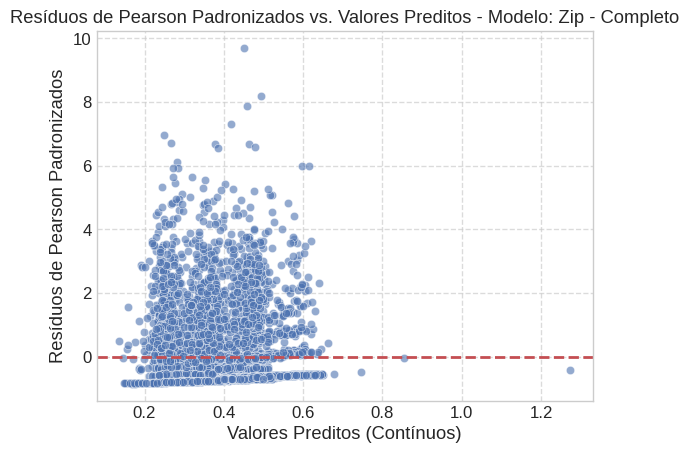

In [50]:
overdisp_plot(modelo_zip, 'Zip - Completo')

Igual ao modelo Poisson, o modelo ZIP apresenta problemas de sobredispersão, quando a média é menor que a variância. O modelo tem diculdades para modelar os componentes de contagem e zeros estruturais uma vez que o presuposto do modelo Poisson não foi atendido e todos as features foram incluídas em ambos componentes.

In [51]:
vuong_test(modelo_poisson, modelo_zip)

         Current function value: 2.994514
         Iterations: 35
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -29.65
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


In [97]:
diagnosticar_dispersao_ct(modelo_zip, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(16.52646715916518),
 'p_valor': np.float64(6.915133531300313e-60)}

Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

##### Stepwise

In [52]:
X1 = X.drop(columns=['frauds']).copy()

In [53]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='LLF',
    cov_type='HC1',
    verbose=False,
    method='bfgs',
    convergence_strictness='low',
    shuffle_features=True,
    shuffle_random_state=45
)
random_selector = RandomFeatureSelector(step_wise, max_features=0.75, scoring_fn=lambda model: model.final_model_.llf, random_state=45)
random_selector.fit(X1, y)

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/26 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/20 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/20 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/26 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/20 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/20 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/20 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/19 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/18 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/17 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/16 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/15 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/14 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/13 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/12 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/10 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/7 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/4 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/26 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/11 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/9 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

Stepwise Selection:   0%|          | 0/50 [00:00<?]

  Testing features:   0%|          | 0/27 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/25 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/24 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/23 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/22 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/21 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/20 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/8 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/6 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/5 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/3 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/2 [00:00<?, ?it/s]

  Testing features:   0%|          | 0/1 [00:00<?, ?it/s]

RandomFeatureSelector(estimator=SimpleStepwiseZeroInflated(convergence_strictness='low',
                                                           selection_criterion='LLF',
                                                           verbose=False),
                      max_features=0.75, random_state=45,
                      scoring_fn=<function <lambda> at 0x7fb584469da0>)

In [79]:
modelo_zip_stepwise = random_selector.best_estimator_#models_[9].final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                 5387
Model:             ZeroInflatedPoisson   Df Residuals:                     5375
Method:                            MLE   Df Model:                           11
Date:                 Tue, 19 Aug 2025   Pseudo R-squ.:                  0.1394
Time:                         11:49:26   Log-Likelihood:                -9843.2
converged:                        True   LL-Null:                       -11438.
Covariance Type:             nonrobust   LLR p-value:                     0.000
=====================================================================================================================
                                                        coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------
inflate_const                                        -0.8161      1.410     -0.579      0.563      -3.579       1.947
inflate_amount_amount_discretized_2                   5.9785      1.374      4.351      0.000       3.285       8.672
inflate_credit_limit_credit_limit_discretized_1     -12.7610      2.702     -4.723      0.000     -18.057      -7.465
inflate_amount_amount_discretized_4                   6.4191      1.532      4.191      0.000       3.417       9.421
inflate_credit_score_credit_score_discretized_1       6.2235      2.820      2.207      0.027       0.697      11.750
inflate_credit_limit_credit_limit_discretized_0      -6.2844      2.910     -2.159      0.031     -11.988      -0.580
inflate_credit_limit_credit_limit_discretized_2       6.3925      2.908      2.198      0.028       0.693      12.092
const                                              1051.0166     34.489     30.474      0.000     983.420    1118.613
transaction_per_client                                2.2466      0.060     37.340      0.000       2.129       2.365
target_city_0                                      -503.5144     21.462    -23.461      0.000    -545.579    -461.450
target_description_0                               -552.6466     28.325    -19.511      0.000    -608.162    -497.131
current_age_current_age_discretized_0                 4.6588      0.664      7.013      0.000       3.357       5.961
amount_amount_discretized_0                           2.6976      0.331      8.146      0.000       2.049       3.347
credit_limit_credit_limit_discretized_1              -6.1002      0.898     -6.792      0.000      -7.861      -4.340
amount_amount_discretized_4                           3.6344      0.612      5.940      0.000       2.435       4.834
credit_score_credit_score_discretized_1               3.2503      0.980      3.318      0.001       1.330       5.170
per_capita_income_per_capita_income_discretized_0     3.3956      1.035      3.280      0.001       1.366       5.425
current_age_current_age_discretized_2                 2.7939      0.915      3.054      0.002       1.001       4.587
per_capita_income_per_capita_income_discretized_4    -2.4871      1.021     -2.436      0.015      -4.488      -0.486
=====================================================================================================================
"""

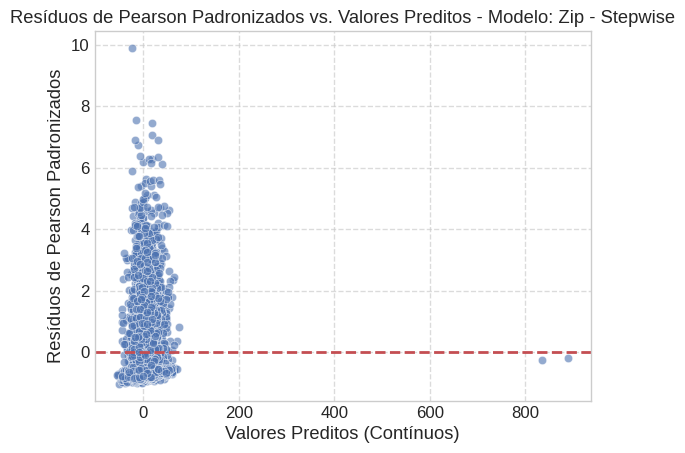

In [80]:
overdisp_plot(modelo_zip_stepwise, 'Zip - Stepwise')

In [96]:
diagnosticar_dispersao_ct(modelo_zip_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(17.39419648179411),
 'p_valor': np.float64(5.644758879107117e-66)}

In [ ]:
vuong_test(modelo_poisson_stepwise, modelo_zip_stepwise)

O modelo apresentou uma melhora significativa em relação ao modelo zip completo uma vez que agora os residuos estão bem mais espelhados em torno da linha vermelha (y=0). No entanto ainda é perceptivo uma dispersão maior ao longo que os valores preditos aumentam, indicando ainda sobredispersão.

Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância é maior que a média.

In [ ]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

##### Completo

In [ ]:
X1 = X.drop(columns=['frauds']).copy(deep=True)
X1 = sm.add_constant(X1)

In [ ]:
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1).fit(disp=False,  method='lbfgs', cov_type='HC1')
modelo_zinb.summary()

In [ ]:
overdisp_plot(modelo_zinb, 'Zip - Completo')

In [ ]:
diagnosticar_dispersao_ct(modelo_zinb, y)

O gráfico mostra que o modelo prevê quase sempre valores próximos de zero, mas quando ocorrem contagens positivas ele não consegue explicar bem, gerando erros muito grandes.
Isso significa que o modelo está superestimando zeros e subestimando casos com eventos reais.
Os resíduos deveriam se espalhar de forma equilibrada em torno de zero, mas aqui aparecem concentrados e com cauda longa para cima, sinal claro de mau ajuste.

In [ ]:
vuong_test(modelo_binomial, modelo_zinb)

##### Stepwise

In [ ]:
X1 = X.drop(columns=['frauds']).copy()

In [ ]:
step_wise = SimpleStepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
    cov_type='HC1',
    verbose=False,
    method='bfgs',
    convergence_strictness='low',
    shuffle_features=True,
    shuffle_random_state=40
)
random_selector = RandomFeatureSelector(step_wise, max_features=0.75, scoring_fn=lambda model: model.final_model_.llf, random_state=40)
random_selector.fit(X1, y)

In [ ]:
modelo_zinb_stepwise = random_selector.models_[4].final_model_
modelo_zinb_stepwise.summary()

In [ ]:
overdisp_plot(modelo_zinb_stepwise, 'ZIMB - Stepwise')

In [ ]:
diagnosticar_dispersao_ct(modelo_zinb_stepwise, y)

O modelo stepwise apresenta previsões mais altas e consistentes, evitando o excesso de zeros visto no modelo anterior.
Os resíduos estão mais próximos de zero e com menor amplitude, sinal de um ajuste mais estável.
Ainda assim, surgem faixas verticais de pontos, indicando previsões pouco flexíveis e repetitivas.
Existem alguns resíduos acima de 5, mostrando que erros relevantes ainda ocorrem.

In [ ]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

### Comparação dos modelos com base em seu Log-Likelihood Function (LLF)

In [ ]:
compare_models({
    'modelo':[
        'Poisson Completo',
        'Poisson StepWise',
        'Binomial Completo',
        'Binomial Stepwise',
        'ZIP Completo',
        'ZIP Stepwise',
        'ZINB Completo',
        'ZINB Stepwise'
    ],
    'loglik':[
        modelo_poisson.llf,
        modelo_poisson_stepwise.llf,
        modelo_binomial.llf,
        modelo_binomial_stepwise.llf,
        modelo_zip.llf,
        modelo_zip_stepwise.llf,
        modelo_zinb.llf,
        modelo_zinb_stepwise.llf
      ]
})

Analisando diretamente a métrica do LLF podemos ver claramente que o modelo ZINB obeteve um melhor resultado, sugerindo que esse possa ser o melho modelo, no entanto será necessário validar outros aspectos a fim de garantir que esse modelo realmente possa ser utilizado.

In [ ]:
titles = [
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Completo',
    'ZIP Stepwise',
    'ZINB Completo',
    'ZINB Stepwise'
]
models = [
    modelo_poisson,
    modelo_poisson_stepwise,
    modelo_binomial,
    modelo_binomial_stepwise,
    modelo_zip,
    modelo_zip_stepwise,
    modelo_zinb,
    modelo_zinb_stepwise
]

### Dispersão dos residuos

In [ ]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 2, i + 1)
    overdisp_plot(model, titles[i], "{}")

plt.tight_layout()
plt.show()

Com base nos residuos de cada modelos em relação ao valor predito, podemos observar que o modelo ZINB Stepwise apresenta uma melhor distribuição dos residuos não apresentando um padrão fixo nos dados, sua dispersão é a menor em relação aos outros modelos e com poucos pontos extremos.

### Análise das métricas dos modelos

In [ ]:
metrics = []
for title, model in zip(titles, models):
  metric = dict(title=title, LLF=model.llf, BIC=model.bic, AIC=model.aic, Converged=model.converged)

  if np.isnan(model.llf):
    continue

  rmse_resid = np.sqrt(np.mean(model.resid_pearson**2))
  outliers = np.sum(np.abs(model.resid_pearson) > 2)

  if hasattr(model, 'prsquared'):
    metric['PseudoR2'] = model.prsquared
  else:
    metric['PseudoR2'] = model.pseudo_rsquared()
  metric['RMSE_Pearson'] = rmse_resid
  metric['Outliers'] = outliers

  metrics.append(metric)

In [ ]:
df_metrics = pd.DataFrame(metrics)
df_metrics.sort_values(by=['LLF', 'Converged'], ascending=False).reset_index(drop=True)

In [ ]:
df_metrics = df_metrics.query('Converged == True').sort_values(by=['BIC'], ascending=True).reset_index(drop=True)
df_metrics

Percebemos que o modelo com maior LLF não convergiu durante o treinamento, o que invalida sua escolha uma vez que os pesos obtidos não refletem a correta relação dos dados com o modelo escohido.

In [ ]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo (convergidos)', fontsize=16)

# Cor de destaque para o melhor modelo e cor padrão para os outros
highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('Métrica AIC dos Modelos (Menor é Melhor)')
# Ordena os valores para o gráfico
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
# Encontra o nome do melhor modelo (menor AIC)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['title']
# Cria a paleta de cores: destaca o melhor modelo
palette_aic = [highlight_color if title == best_model_aic else default_color for title in df_sorted['title']]
# Plota o gráfico com a paleta de cores
sns.barplot(data=df_sorted, y='title', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('Métrica BIC dos Modelos (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['title']
palette_bic = [highlight_color if title == best_model_bic else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('Métrica LLF dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['title']
palette_llf = [highlight_color if title == best_model_llf else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhança)')
plt.ylabel('Modelos')

# --- Subplot 4: Pseudo R² ---
plt.subplot(2, 2, 4)
plt.title('Métrica Pseudo R² dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='PseudoR2', ascending=False)
best_model_r2 = df_metrics.loc[df_metrics['PseudoR2'].idxmax()]['title']
palette_r2 = [highlight_color if title == best_model_r2 else default_color for title in df_sorted['title']]
sns.barplot(data=df_sorted, y='title', x='PseudoR2', palette=palette_r2)
plt.xlabel('$Pseudo \ R^2$')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para não sobrepor o super-título
plt.show()

Podemos perceber que o modelo ZINB Stepwise se demonstra melhor em duas métricas, LLF e AIC, sendo assim a melhor escolha.

## Análise do melhor modelo

#### Seleção do melhor modelo

In [ ]:
best_model = df_metrics.loc[0, 'title']
best_model

In [ ]:
indice = titles.index(best_model)
best_model = models[indice]
best_model.summary()

#### Tabela de features

In [ ]:
df_exog_inf = best_model.model.exog_infl
feature_exog_inf = [column for column in best_model.model.exog_names if ('inflate_' in column)]
df_exog_inf = pd.DataFrame(df_exog_inf, columns=feature_exog_inf)

In [ ]:
df_exog = best_model.model.exog
features_exog = [column for column in best_model.model.exog_names if not ('inflate_' in column or 'alpha' in column)]
df_exog = pd.DataFrame(df_exog, columns=features_exog)

In [ ]:
df_features = pd.concat([df_exog, df_exog_inf], axis=1)
df_features['residuos'] = best_model.resid_pearson
df_features['fitted'] = best_model.fittedvalues
df_features['target'] = y
df_features

#### Análises de resíduos padronizados

##### Histograma

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(df_features["residuos"], kde=True, color='skyblue')
plt.title("Histograma e KDE dos Resíduos Padronizados")
plt.xlabel("Resíduos Padronizados")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

##### Análise dos residuos com um quantis teóricos

In [ ]:
sm.qqplot(df_features["residuos"], line='45', fit=True)
plt.title("QQ-Plot dos Resíduos Padronizados")
plt.tight_layout()
plt.show()

##### Testes de normalidades de resíduos

In [ ]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(df_features["residuos"])
print(f"[Shapiro-Wilk] Estatística: {shapiro_stat:.4f} | p-valor: {shapiro_p:.4f}")

alpha = 0.05
if shapiro_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

In [ ]:
# D’Agostino and Pearson's test
dagostino_stat, dagostino_p = stats.normaltest(df_features["residuos"])
print(f"[D’Agostino] Estatística: {dagostino_stat:.4f} | p-valor: {dagostino_p:.4f}")

alpha = 0.05  # nível de significância
if dagostino_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

##### Teste de validação de homocedasticidade



In [ ]:
X = sm.add_constant(df_features["fitted"])
model_bp = sm.OLS(df_features["residuos"], X).fit()
bp_test = het_breuschpagan(model_bp.resid, X)
bp_labels = ['LM Stat', 'LM p-val', 'F Stat', 'F p-val']

print("\n[Breusch-Pagan]")
for label, val in zip(bp_labels, bp_test):
    print(f"{label}: {val:.4f}")

# Define o nível de significância (alpha)
alpha = 0.05
p_valor_lm = bp_test[1] # p-valor da estatística LM é o mais comum

print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
print("H₀ (Hipótese Nula): O modelo é homocedástico (variância dos erros é constante).")
print("Hₐ (Hipótese Alternativa): O modelo é heterocedástico (variância dos erros não é constante).")

if p_valor_lm < alpha:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MENOR que {alpha}.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo APRESENTA HETEROCEDASTICIDADE.")
else:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MAIOR ou IGUAL a {alpha}.")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo é HOMOCEDÁSTICO.")


##### Teste de autocorrelação de resíduos

In [ ]:
# Teste de Autocorrelação (Durbin-Watson)
dw_stat = durbin_watson(df_features["residuos"])

print(f"\n--- Resultado do Teste de Durbin-Watson ---")
print(f"Estatística d: {dw_stat:.4f}")

# --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
print(f"\n--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---")
print("H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.")
print("Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.")

if dw_stat < 1.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MENOR que 1.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO POSITIVA.")

elif dw_stat > 2.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MAIOR que 2.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO NEGATIVA.")

else: # A estatística está entre 1.5 e 2.5
    print(f"\nResultado: A estatística ({dw_stat:.4f}) está dentro da faixa segura [1.5, 2.5].")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste NÃO indica a presença de autocorrelação de primeira ordem.")


In [ ]:
validar_autocorrelacao_ljung_box(best_model.resid_pearson)

In [ ]:
plot_acf_pacf(best_model.resid_pearson, 10)

## Inferência Estatistica

In [ ]:
# # Estilo mais profissional e consistente
# sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

# # Paleta de cores
# point_color = "#1f77b4"  # azul elegante
# line_color = "#d62728"   # vermelho para linha horizontal

# # Seleciona colunas para análise
# cols_plot = [c for c in df_features.columns if c not in ['fitted', 'residuos', 'target', 'Valores Ajustados (Fitted) ']]

# # Número total de gráficos
# n_plots = len(cols_plot) + 1  # +1 para incluir o de valores ajustados
# n_rows = (n_plots + 1) // 2   # duas colunas

# # Cria figura e eixos
# fig, axes = plt.subplots(n_rows, 2, figsize=(14, 5 * n_rows))
# axes = axes.flatten()

# # 1) Resíduos vs. variáveis explicativas
# for i, col in enumerate(cols_plot):
#     sns.scatterplot(data=df_features, x=col, y='residuos',
#                     s=50, alpha=0.7, edgecolor="k", color=point_color, ax=axes[i])
#     axes[i].axhline(0, linestyle='--', color=line_color, linewidth=1.2)
#     axes[i].set_title(f"Análise de Resíduos vs. {col}", fontsize=14, weight="bold")
#     axes[i].set_xlabel(col, fontsize=12)
#     axes[i].set_ylabel("Resíduos", fontsize=12)

# # 2) Resíduos vs. Valores Ajustados
# idx = len(cols_plot)
# sns.scatterplot(x=df_features['fitted'], y=df_features['residuos'],
#                 s=50, alpha=0.7, edgecolor="k", color=point_color, ax=axes[idx])
# axes[idx].axhline(0, linestyle='--', color=line_color, linewidth=1.2)
# axes[idx].set_title("Análise de Resíduos vs. Valores Ajustados", fontsize=14, weight="bold")
# axes[idx].set_xlabel("Valores Ajustados (Fitted)", fontsize=12)
# axes[idx].set_ylabel("Resíduos", fontsize=12)

# # Remove eixos extras se sobrar espaço
# for j in range(idx + 1, len(axes)):
#     fig.delaxes(axes[j])

# plt.tight_layout()
# plt.show()


In [ ]:
def interpretar_componente_inflacao(inflation_coeffs: pd.DataFrame, alpha_level: float = 0.05):
    """
    Interpreta os coeficientes do componente de inflação (Logit) do modelo ZINB.

    Args:
        inflation_coeffs (pd.DataFrame): DataFrame com os resultados do componente de inflação.
        alpha_level (float): Nível de significância para testes de hipótese.
    """
    print("="*80)
    print("Análise Inferencial do Componente de Inflação (Modelo Logístico)")
    print("Este componente modela a probabilidade de um indivíduo pertencer ao grupo de 'não fraudadores'.")
    print("="*80 + "\n")

    for var, row in inflation_coeffs.iterrows():
        coef = row['coef']
        p_value = row['P>|z|']

        # Ignora o intercepto para a interpretação de Odds Ratio
        if 'const' in var:
            print(f"Intercepto (inflate_const): {coef:.4f}")
            print("  - O log-odds base de pertencer ao grupo de 'não fraudadores' (quando todas as outras variáveis são zero ou categoria de referência) é de 2.3167.\n")
            continue

        odds_ratio = np.exp(coef)

        print(f"Variável: {var}")
        print(f"  - Coeficiente (Log-Odds): {coef:.4f}")
        print(f"  - Odds Ratio (OR): {odds_ratio:.4f}")
        print(f"  - P-valor: {p_value:.4f}")

        if p_value < alpha_level:
            print("  - Conclusão: Efeito ESTATISTICAMENTE SIGNIFICATIVO.")
            if odds_ratio > 1:
                increase_pct = (odds_ratio - 1) * 100
                print(f"  - Interpretação: A presença desta categoria aumenta a chance (odds) de um indivíduo ser um 'não fraudador' em {increase_pct:.2f}%, em comparação com a categoria de referência, mantendo as outras variáveis constantes.")
            else:
                decrease_pct = (1 - odds_ratio) * 100
                print(f"  - Interpretação: A presença desta categoria diminui a chance (odds) de um indivíduo ser um 'não fraudador' em {decrease_pct:.2f}%, em comparação com a categoria de referência, mantendo as outras variáveis constantes.")
        else:
            print("  - Conclusão: Efeito ESTATISTICAMENTE NÃO SIGNIFICATIVO.")
            print("  - Interpretação: Não há evidência estatística para afirmar que esta variável influencia a probabilidade de um indivíduo pertencer ao grupo de 'não fraudadores'.")

        print("-" * 40)

def interpretar_componente_contagem(count_coeffs: pd.DataFrame, alpha_level: float = 0.05):
    """
    Interpreta os coeficientes do componente de contagem (Binomial Negativo) do modelo ZINB.

    Args:
        count_coeffs (pd.DataFrame): DataFrame com os resultados do componente de contagem.
        alpha_level (float): Nível de significância para testes de hipótese.
    """
    print("\n" + "="*80)
    print("Análise Inferencial do Componente de Contagem (Modelo Binomial Negativo)")
    print("Este componente modela a contagem esperada de fraudes para o grupo de 'potenciais fraudadores'.")
    print("="*80 + "\n")

    for var, row in count_coeffs.iterrows():
        coef = row['coef']
        p_value = row['P>|z|']
        std_err = row['std err']

        # Alerta para coeficientes potencialmente instáveis
        if abs(coef) > 50 and std_err > 50:
            print("*"*5 + " ALERTA DE POTENCIAL INSTABILIDADE NUMÉRICA " + "*"*5)
            print(f"A variável '{var}' possui um coeficiente ({coef:.2f}) e erro padrão ({std_err:.2f}) muito grandes.")
            print("Isso pode indicar separação nos dados. O efeito é forte e na direção indicada, mas a magnitude exata deve ser vista com cautela.\n")

        # Ignora o intercepto para a interpretação de IRR
        if 'const' in var:
            print(f"Intercepto (const): {coef:.4f}")
            print(f"  - O log da contagem esperada de fraudes base é {coef:.4f} para o grupo de 'potenciais fraudadores' (quando todas as outras variáveis são zero ou categoria de referência).\n")
            continue

        irr = np.exp(coef)

        print(f"Variável: {var}")
        print(f"  - Coeficiente (Log-Count): {coef:.4f}")
        print(f"  - Incidence Rate Ratio (IRR): {irr:.4f}")
        print(f"  - P-valor: {p_value:.4f}")

        if p_value < alpha_level:
            print("  - Conclusão: Efeito ESTATISTICAMENTE SIGNIFICATIVO.")
            if irr > 1:
                increase_pct = (irr - 1) * 100
                print(f"  - Interpretação: A presença desta categoria aumenta a contagem esperada de fraudes em {increase_pct:.2f}%, em comparação com a categoria de referência, para o grupo de 'potenciais fraudadores'.")
            else:
                decrease_pct = (1 - irr) * 100
                print(f"  - Interpretação: A presença desta categoria diminui a contagem esperada de fraudes em {decrease_pct:.2f}%, em comparação com a categoria de referência, para o grupo de 'potenciais fraudadores'.")
        else:
            print("  - Conclusão: Efeito ESTATISTICAMENTE NÃO SIGNIFICATIVO.")
            print("  - Interpretação: Não há evidência estatística para afirmar que esta variável influencia a contagem de fraudes para o grupo de 'potenciais fraudadores'.")

        print("-" * 40)



In [ ]:
def analisar_inferencia_zinb_dinamico(results_df: pd.DataFrame):
    """
    Função que orquestra a análise a partir de um DataFrame de resultados.
    """
    # Separar os componentes do modelo
    inflation_vars = [idx for idx in results_df.index if idx.startswith('inflate_')]
    count_vars = [idx for idx in results_df.index if not idx.startswith('inflate_') and idx != 'alpha']

    # OBS: os nomes das colunas podem variar ligeiramente. Verifique com `print(results_df.columns)`
    # Nomes comuns são: ['Coef.', 'Std.Err.', 'z', 'P>|z|', '[0.025', '0.975]']
    # O seu output original tinha 'coef', 'std err', etc. O default de .summary2() é 'Coef.', 'Std.Err.'
    # Vamos renomear para manter a compatibilidade com o script anterior
    results_df.rename(columns={
        'Coef.': 'coef',
        'Std.Err.': 'std err',
        'P>|z|': 'P>|z|'
    }, inplace=True)

    count_results = results_df.loc[count_vars]

    # Chamar a função de interpretação
    interpretar_componente_contagem(count_results)

In [ ]:
best_model.summary()

In [ ]:
results_df = best_model.summary2().tables[1]
analisar_inferencia_zinb_dinamico(results_df)